In [35]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import integrate, optimize
from iminuit import Minuit
from tqdm import tqdm
from itertools import product
from multiprocessing import Pool
import os
plt.rcParams.update({'font.size': 18})
saving_index = 1
path = f'./top_mass_JSF_param/template_param{saving_index}'
if not os.path.exists(path): os.mkdir(path)

## Parameters definition
1. bins related parameters (reconstucted top mass)
* bins_width (int): The width of each bin (for both reconstructed top mass and W mass)
* top_bins_min (int): The minimum reco top mass (GeV)
* top_bins_max (int): The maximum reco top mass (GeV)
* top_bins (float array): The boundary of each bin i.g. 120, 121, 122
* top_bins_mid(float array): The central value of bins, it will be generated automatically
* top_bins_dense(float array): Dense version of top bins, which is used to draw fitted line

2. bins related parameters (reconstucted W mass)
* W_bins_min (int): The minimum W mass (GeV)
* W_bins_max (int): The maximum W mass (GeV)
* W_bins (float array): The boundary of each bin
* W_bins_mid(float array): The central value of bins, it will be generated automatically
* W_bins_dense(float array): Dense version of W bins, which is used to draw fitted line

3. True top mass related parameters
* mass(int array): True top mass
* top_mass_dense(float array): Densly true top mass that is used to close the fit result

4. JSF related parameters
* JSF_arr(float array): JSF arr that generates
* JSF_dense(float array): Densly JSF that is used to close the fit result

5. Other parameters
* loglikeli_cut: KLFitter loglikelihood cut, range between -80 to -50
* marginal_prob_cut: SPANet marginal probility cut, range between 0 to 1
* pseudo_event: Toy number of each pseudo experiment

6. Settings
* states: 0 for unmatched, 1 for incorrect, and 2 for correct
* state_labels: The label of three states
* colors: Control the color of drawings
* langau_fit_labels: The label of parameters for reconstructed top mass pdf fit
* twogau_fit_labels: The label of parameters for reconstructed W mass pdf fit

In [36]:
# Fixed the bins, colors, mass arr, and labels for all plots.
# 1. bins related parameters (reconstucted top mass)
bins_width = 1
top_bins_min, top_bins_max = 120, 230
top_bins = np.arange(top_bins_min, top_bins_max+1, bins_width)
top_bins_mid = top_bins[:-1]+bins_width/2
top_bins_dense = np.linspace(top_bins_min, top_bins_max, 1000)

# 2. bins related parameters (reconstucted W mass)
W_bins_min, W_bins_max = 40, 120
W_bins = np.arange(W_bins_min, W_bins_max+1, bins_width)
W_bins_mid = W_bins[:-1]+bins_width/2
W_bins_dense = np.linspace(W_bins_min, W_bins_max, 1000)

# 3. True top mass related parameters
mass = [170, 171, 172, 173, 174, 175, 176]
top_mass_dense = np.linspace(170, 176, 1000)

# 4. JSF related parameters
JSF_arr = [0.96, 1.0, 1.04]
JSF_dense = np.linspace(0.96, 1.04, 1000)

# 5. Other paramters
# Param set 10
loglikeli_cut = -1000
assignmment_cut = 0.0
marginal_prob_cut = 0.0
pseudo_event = 100000

# 6. Settings
states = [0, 1, 2]
state_labels = ['Unmatched', 'Incorrect', 'Correct']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
langau_fit_labels = ['Peak of Landau', 'Width of Landau', 'Mean of Gaussian', 'Variance of Gaussian', 'Fraction of Gaussian']
twogau_fit_labels = ['Mean of first Gaussian', 'Variance of first Gaussian', 'Mean of second Gaussian', 'Variance of second Gaussian', 'Fraction of second Gaussian']


## Function get_reco_top_mass
Input:
1. h5py_file (h5py_file): The h5py file that contains the KLFitter and SPANet result
2. target ("klf", "spanet", or "true"): The target to analysis
3. JSF (float): Jet scaling factor, it scales the energy of bjet and the two light jets

Output:
1. reconstructed top mass (float array)
2. reconstructed W mass(float array)
3. state (int array): State of the top mass, 0 for unmatched, 1 for incorrect, and 2 for correct
4. cuts (bool array): reco top mass cut (bins_min < reco top mass < bins_max)
5. likelihood_cut (bool array): 

In [37]:
def get_reco_mass(h5py_file, target, JSF): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)*JSF
    # py = pt*sin(phi)*JSF
    # pz = pt*sinh(eta)*JSF
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])*JSF
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])*JSF
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])*JSF
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])*JSF
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])*JSF
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])*JSF
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])*JSF
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])*JSF
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])*JSF
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_W_mass'] = np.sqrt((dic['E1']+dic['E2'])**2
                    - (dic['px1']+dic['px2'])**2
                    - (dic['py1']+dic['py2'])**2
                    - (dic['pz1']+dic['pz2'])**2)
    
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    top_bins_min < reco_m_top < top_bins_max
    W_bins_min < reco_W_top < W_bins_max
    """
    reco_cuts = np.logical_and.reduce((dic['reconstructed_top_mass'] > top_bins_min, dic['reconstructed_top_mass'] < top_bins_max, 
                                       dic['reconstructed_W_mass'] > W_bins_min, dic['reconstructed_W_mass'] < W_bins_max))

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    permu1 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    permu2 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    correct = np.logical_and(np.logical_or(permu1, permu2), h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(correct, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts, h5py_file['klfitter/score/loglikelihood'][:]>loglikeli_cut
    elif target == 'permutation_dnn': return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts, h5py_file['permutation_dnn/assignment_score'][:]>assignmment_cut
    elif target == 'spanet': return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts, h5py_file['spanet/right_target/marginal_probability'][:]>marginal_prob_cut
    else: return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts


## Data input
Using the function get_reco_top_mass to retrieve the data from the h5py files

In [49]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct
reco_klf_dic, W_klf_dic, state_klf_dic, cut_klf_dic, likeli_klf_dic = {}, {}, {}, {}, {}
reco_pdnn_dic, W_pdnn_dic, state_pdnn_dic, cut_pdnn_dic, likeli_pdnn_dic = {}, {}, {}, {}, {}
reco_spanet_dic, W_spanet_dic, state_spanet_dic, cut_spanet_dic, likeli_spanet_dic = {}, {}, {}, {}, {}
reco_perfect_dic, W_perfect_dic, state_perfect_dic, cut_perfect_dic = {}, {}, {}, {}

for m in mass:
    for JSF in [1]:
        if JSF == 1: h5py_file = h5py.File(f'test/ttbar_testing_mass_variation/ttbar_testing_{m}_gev_with_spanet_pdnn_KLFitter.h5', "r")
        else: h5py_file = h5py.File(f'ttbar_testing_final_mass_variation_JSF={JSF:.2f}/ttbar_testing_{m}_gev.h5', "r")
        reco_klf_dic[(m, JSF)], W_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)], cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]  = get_reco_mass(h5py_file, 'klfitter', 1)
        reco_pdnn_dic[(m,JSF)], W_pdnn_dic[(m, JSF)], state_pdnn_dic[(m,JSF)], cut_pdnn_dic[(m,JSF)], likeli_pdnn_dic[(m,JSF)] = get_reco_mass(h5py_file, 'permutation_dnn', 1)
        reco_spanet_dic[(m, JSF)], W_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)], cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)] = get_reco_mass(h5py_file, 'spanet', 1)
        reco_perfect_dic[(m,JSF)], W_perfect_dic[(m, JSF)], state_perfect_dic[(m,JSF)], cut_perfect_dic[(m,JSF)] = get_reco_mass(h5py_file, 'target', 1)


KeyError: "Unable to open object (object 'assignment_score' doesn't exist)"

In [28]:
# Sum of a Landau distribution and a gaussian distribution. Landau uses moyal as approximation.
def langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Normalized between top_bins_min and top_bins_max
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, top_bins_min, top_bins_max, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]

# Two gaussian distributions.
def two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    gau_y1 = (x-gau_loc1)/gau_scale1
    gau_y2 = (x-gau_loc2)/gau_scale2
    return (1-f)*np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1 + f*np.exp(-gau_y2**2/2)/np.sqrt(2*np.pi)/gau_scale2

def two_gau_norm(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    return two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f)/integrate.quad(two_gau, W_bins_min, W_bins_max, args=(gau_loc1, gau_scale1, gau_loc2, gau_scale2, f))[0]

# Gaussian distributions.
def gau(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

def gau_norm(x, gau_loc1, gau_scale1):
    return gau(x, gau_loc1, gau_scale1)/integrate.quad(gau, x[0]-bins_width/2, x[-1]+bins_width/2, args=(gau_loc1, gau_scale1))[0]

# Linear
def linear(x, a, b):
    return a*x+b

# Function to construct PDF parameters
def linear_linear(x, a, b, c, d):
    return (a + b*(x[0]-173)) * (c + d*(x[1]-1))

def linear_parabola(x, a, b, c, d, e):
    return (a + b*(x[0]-173)) * (c + d*(x[1]-1) + e*(x[1]-1)**2)

def fcn_top(lan_loc, lan_scale, gau_loc, gau_scale, f):
    return -2*np.sum(hist*np.log(langau_norm(top_bins_mid, lan_loc, lan_scale, gau_loc, gau_scale, f)))*tot_event

def fcn_W(lan_loc, lan_scale, gau_loc, gau_scale, f):
    return -2*np.sum(hist*np.log(two_gau_norm(W_bins_mid, lan_loc, lan_scale, gau_loc, gau_scale, f)))*tot_event

#observed is the observation, pdf is the normalized height of the bins from pdf.
def chi2_pdf_top(target, pdf):
    n1, _ = np.histogram(target, bins=top_bins)
    n2 = pdf*bins_width*len(target)
    return np.sum((n1-n2)**2/n2)

def chi2_pdf_W(target, pdf):
    n1, _ = np.histogram(target, bins=W_bins)
    n2 = pdf*bins_width*len(target)
    return np.sum((n1-n2)**2/n2)

def extract_pred(extracted_top, extracted_JSF, a, b, c, d):
    return a + b*(extracted_top-173) + c*(extracted_JSF-1) + d*(extracted_top-173)*(extracted_JSF-1)

In [29]:
def fit_function(fcn_type, limit):
    popt_arr = defaultdict(list)
    perr_arr = defaultdict(list)
    for _ in range(10):
        tol = 0.01
        start = [np.random.uniform(limit[i][0], limit[i][1]) for i in range(5)]
        while tol<1.28:
            try:
                if fcn_type == 'top': minuit = Minuit(fcn_top, *start)
                else: minuit = Minuit(fcn_W, *start)
                minuit.limits = limit
                minuit.tol = tol
                minuit.migrad()
                minuit.minos()
            except: tol *= 2
            else: break
        if minuit.fval:
            for i in range(5):
                popt_arr[i].append(list(minuit.values)[i])
                perr_arr[i].append(list(minuit.errors)[i])
    
    for i in range(5):
        popt_arr[i] = np.array(popt_arr[i])
        perr_arr[i] = np.array(perr_arr[i])
    select = [True]*len(popt_arr[0])
    for i in [0, 2, 1, 3]:
        x, y = np.histogram(popt_arr[i][select])
        if max(x) >= sum(x)//2:
            index = np.argmax(x)
            select = np.logical_and.reduce((select, popt_arr[i] > y[index], popt_arr[i] < y[index+1]))

    return [np.mean(popt_arr[i][select]) for i in range(5)], [np.mean(perr_arr[i][select]) for i in range(5)]

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_16617/2057602661.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, top_bins_min, top_bins_max, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]


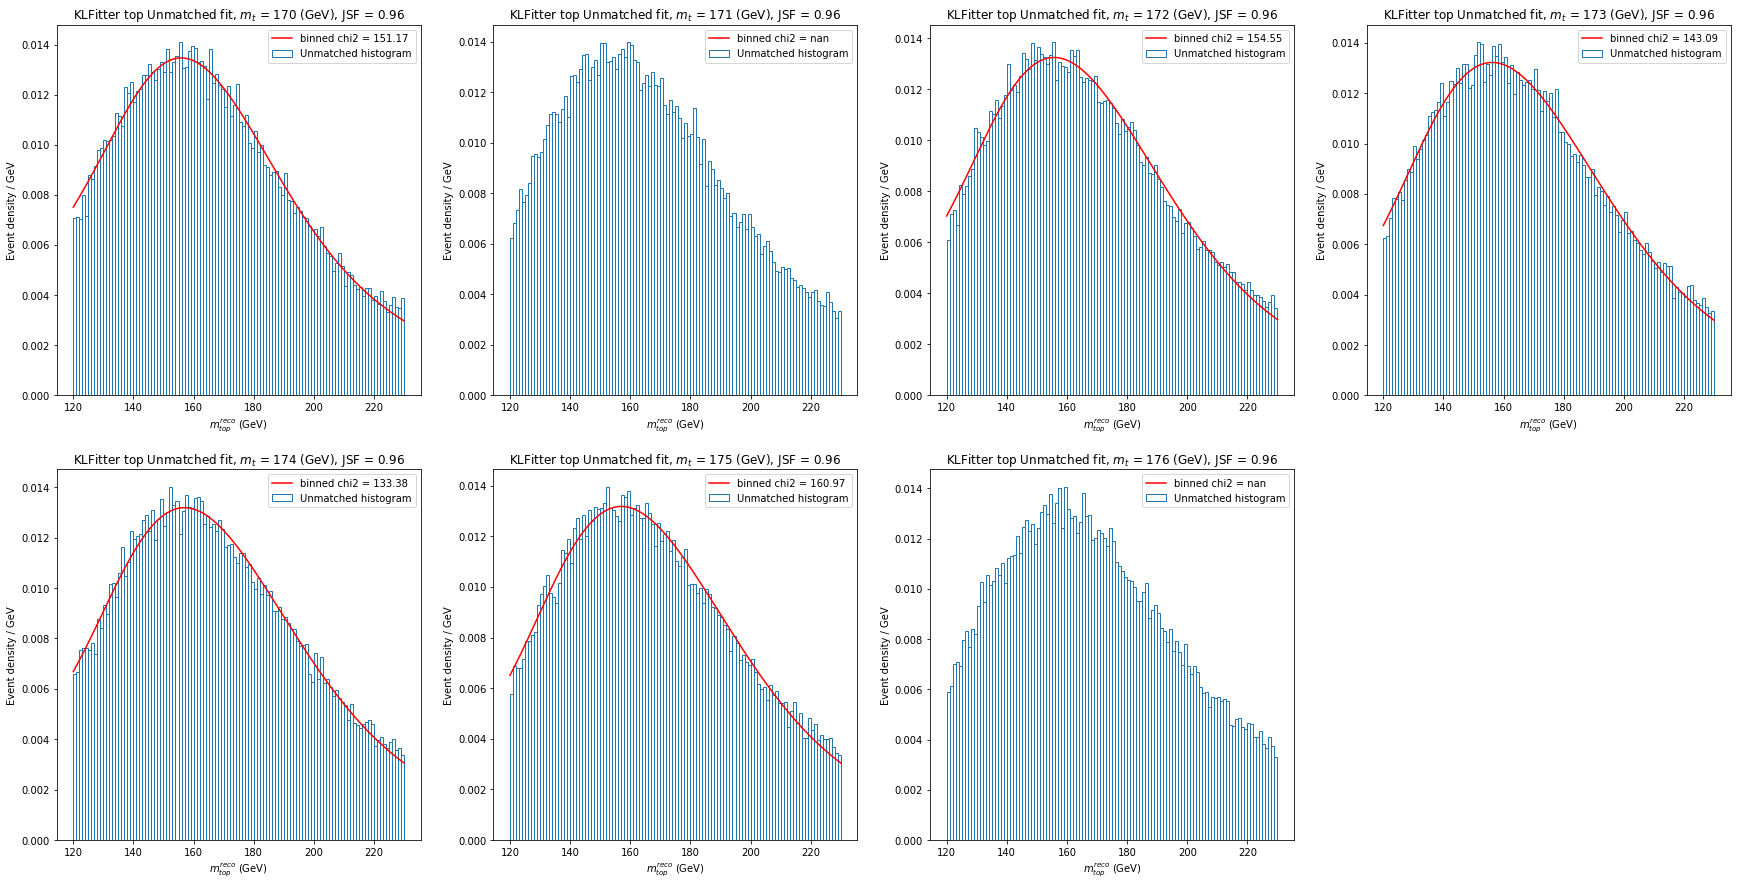

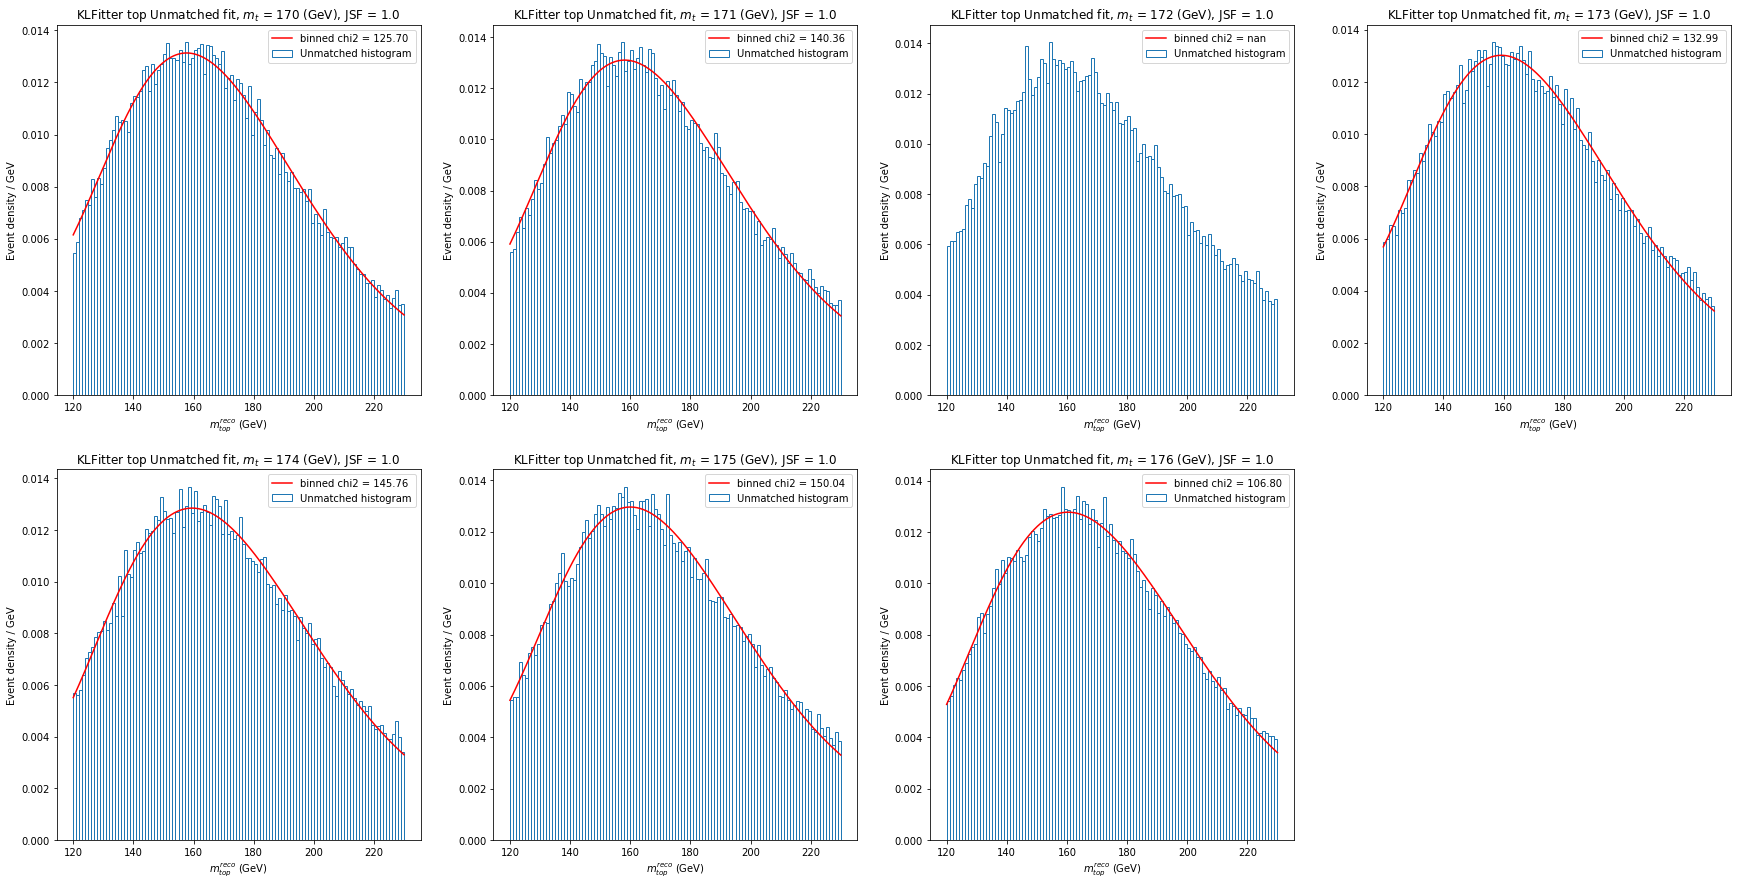

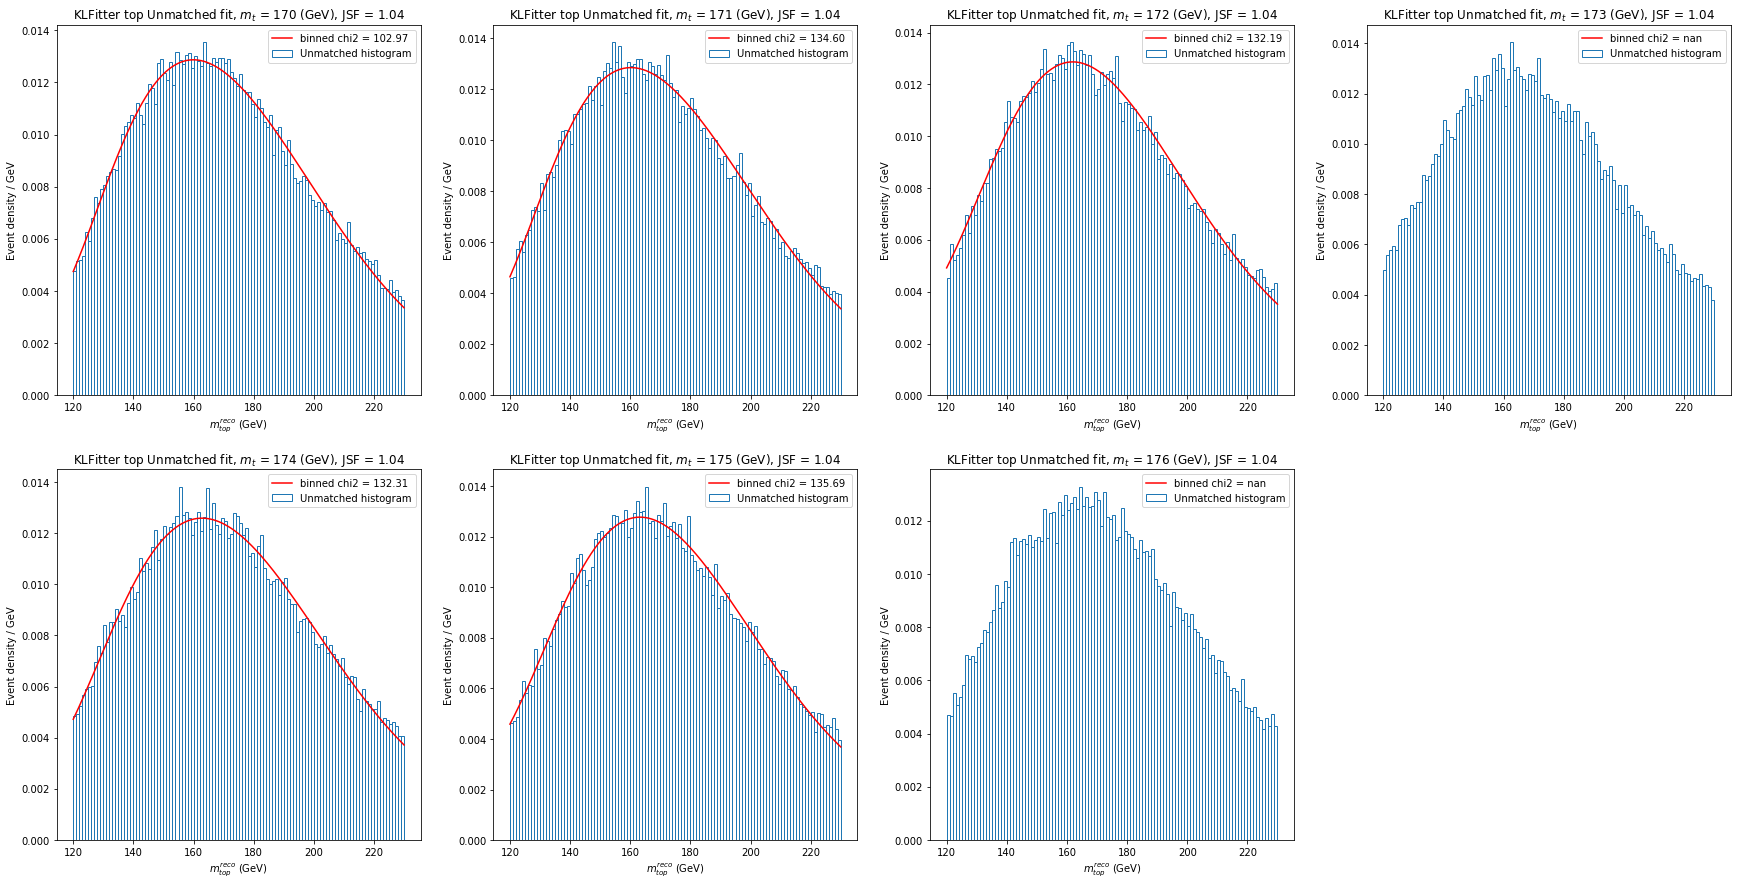

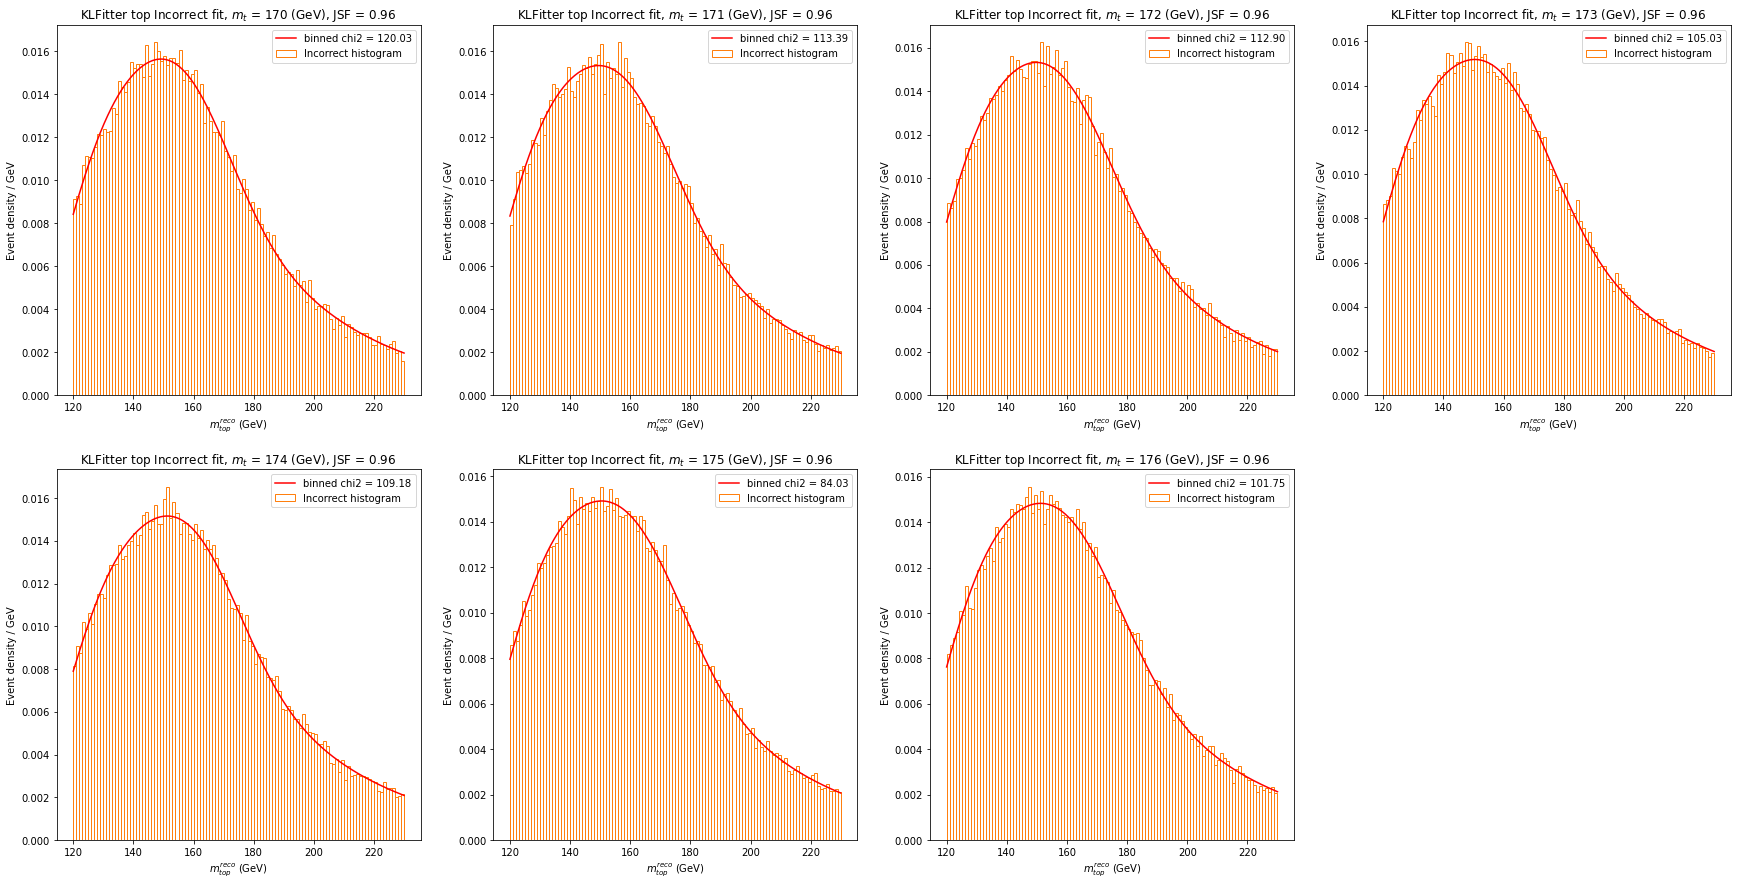

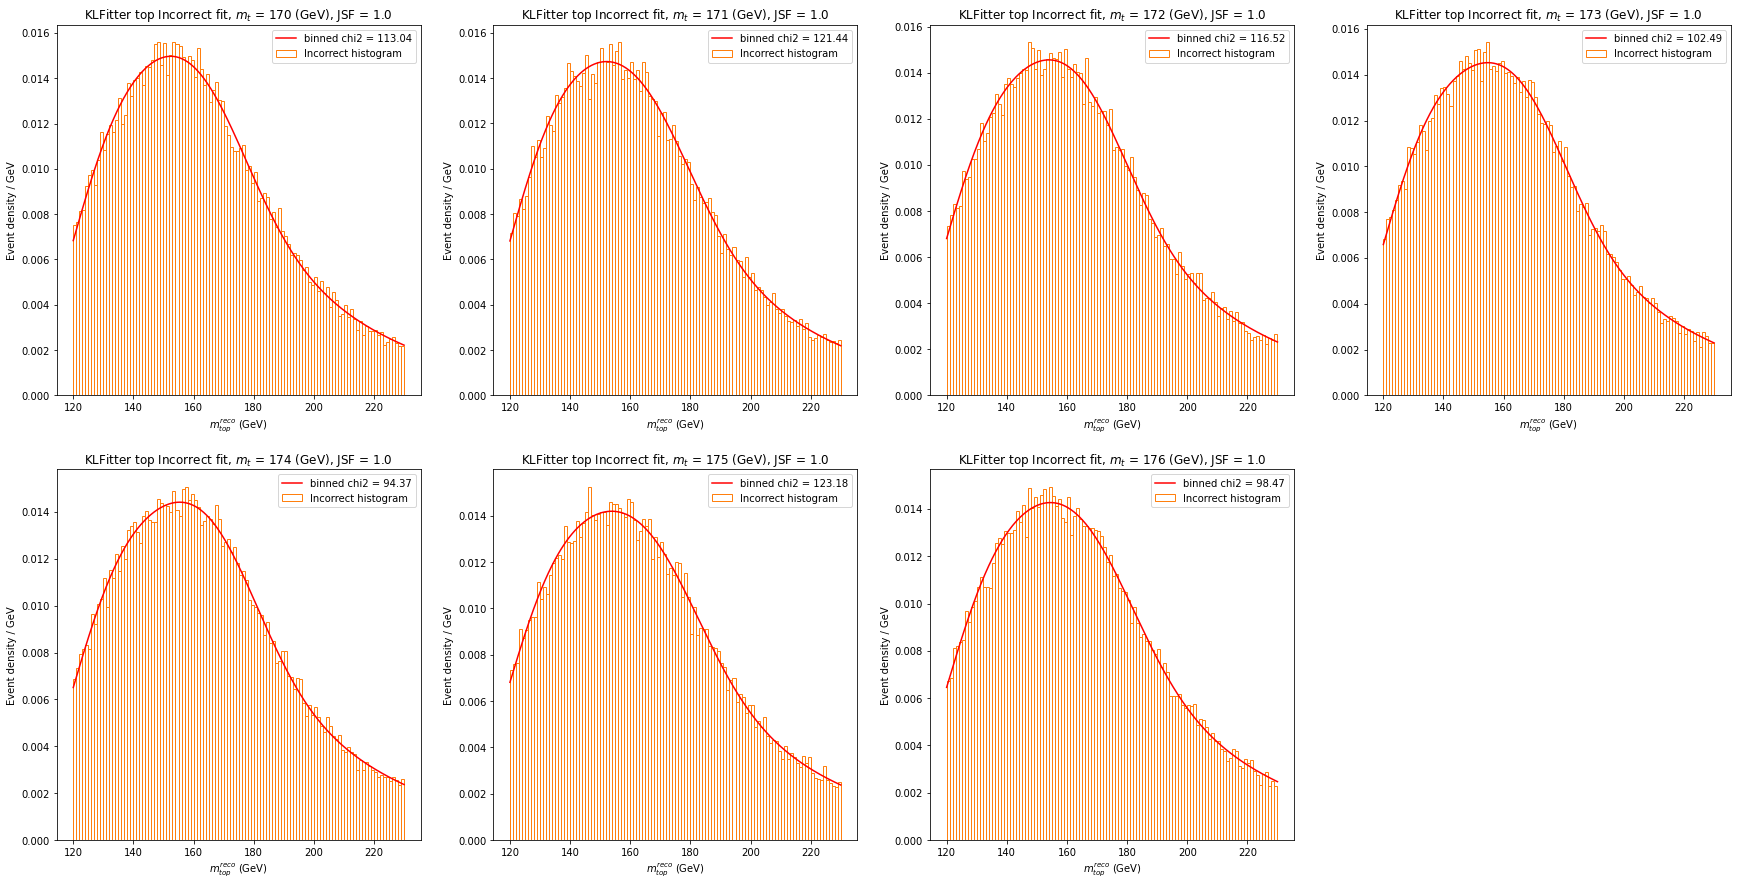

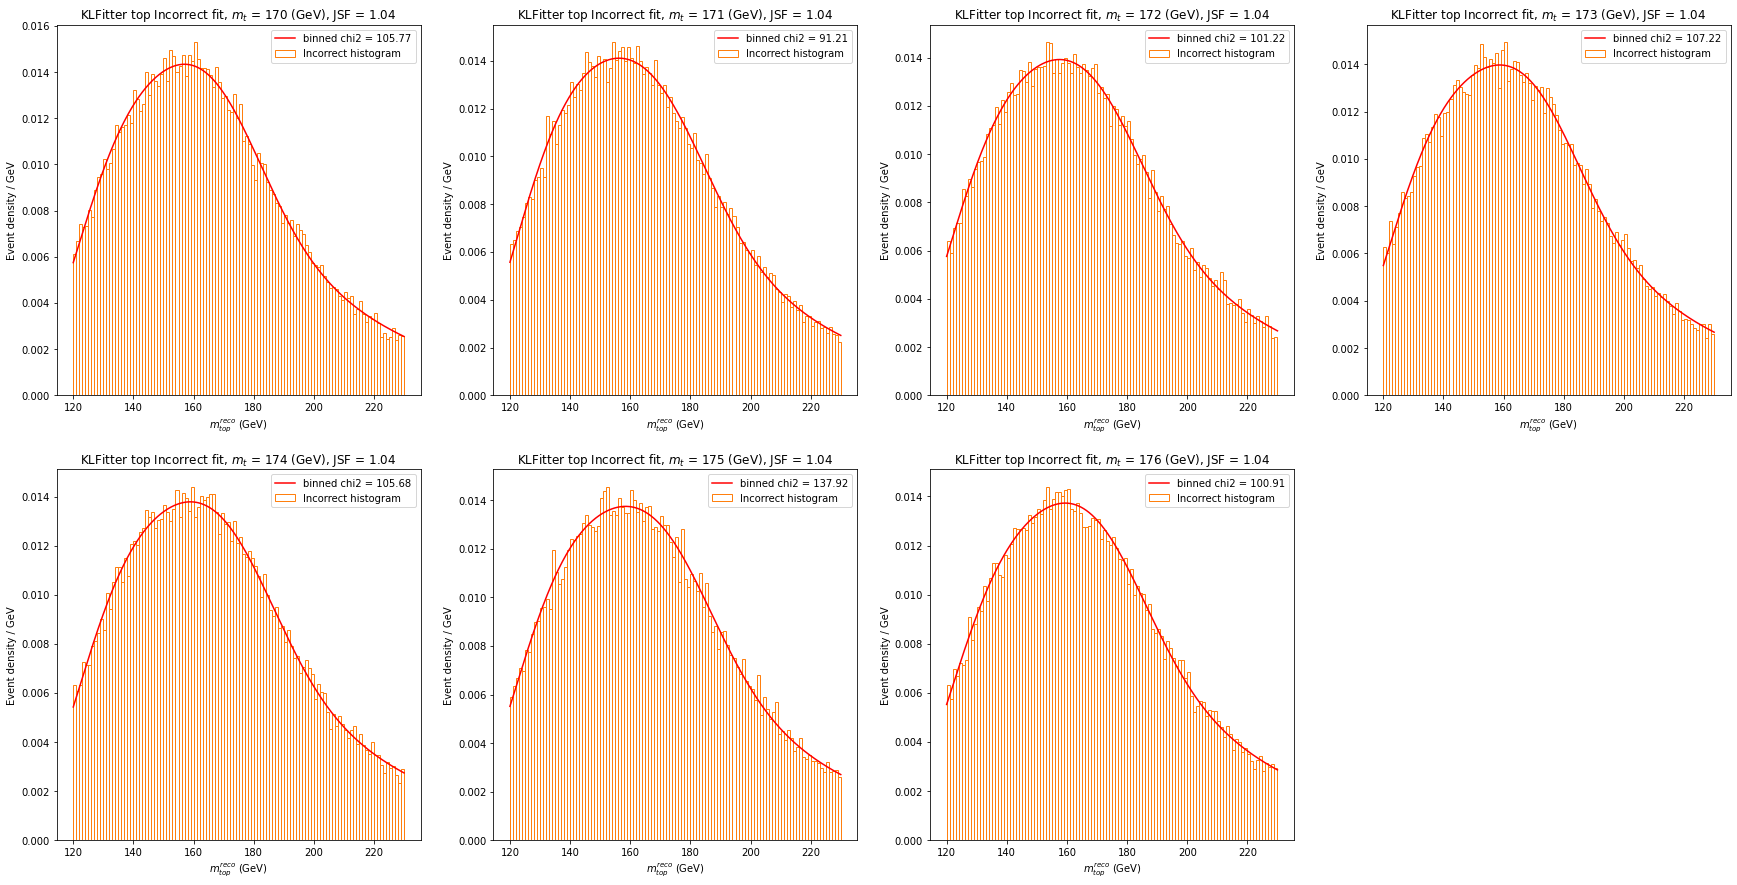

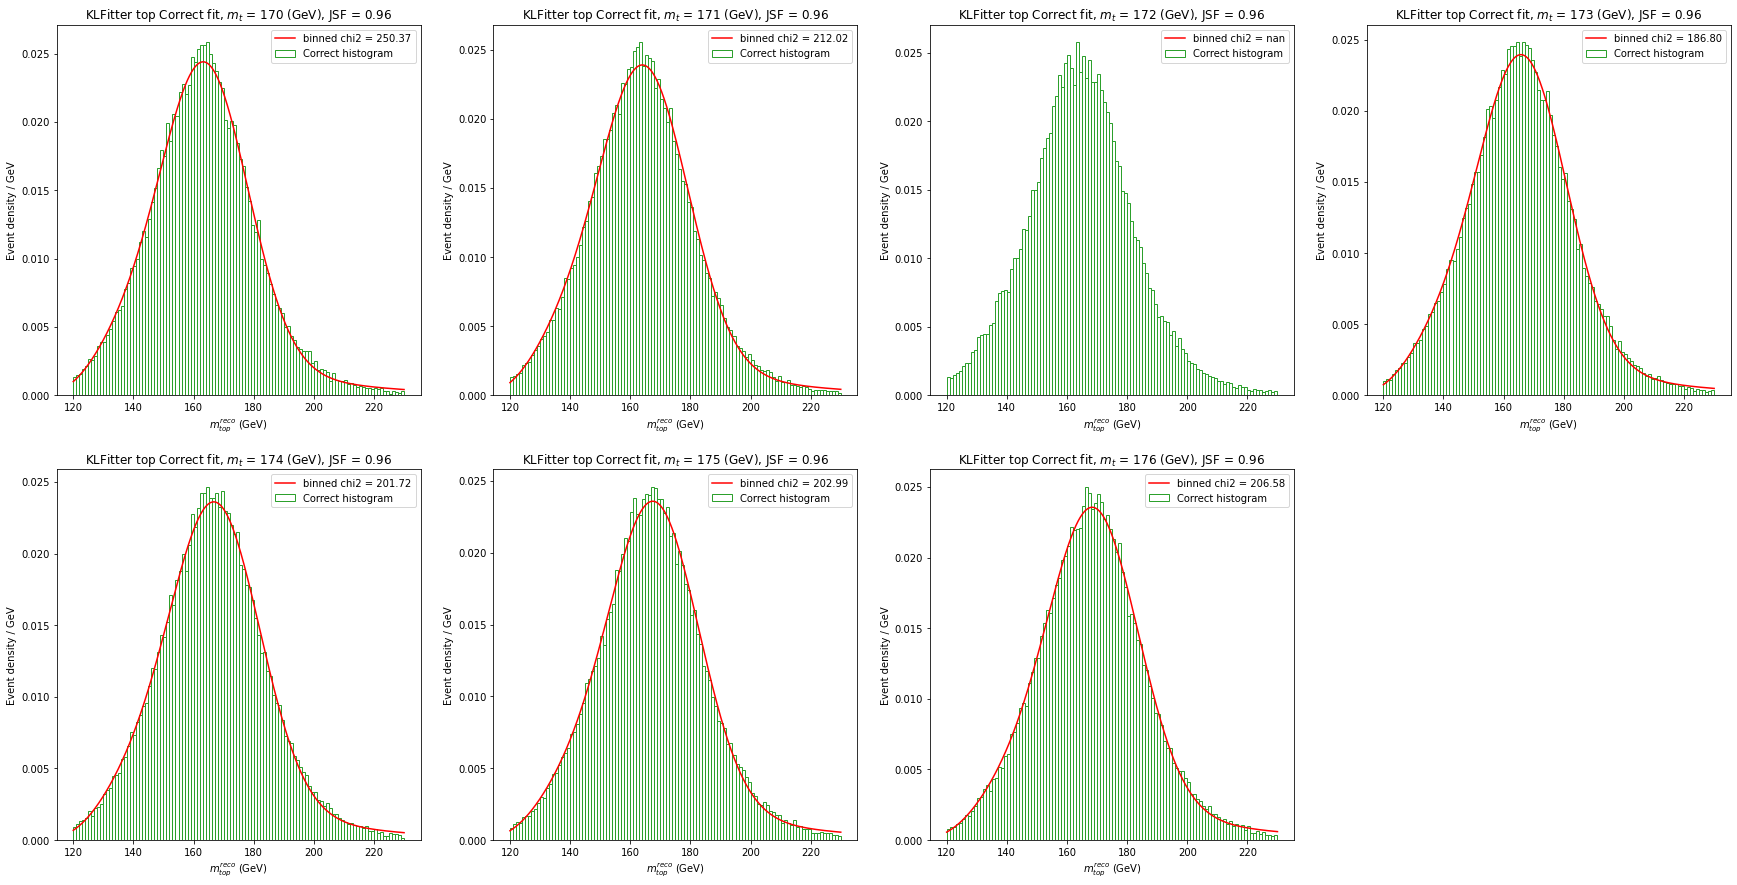

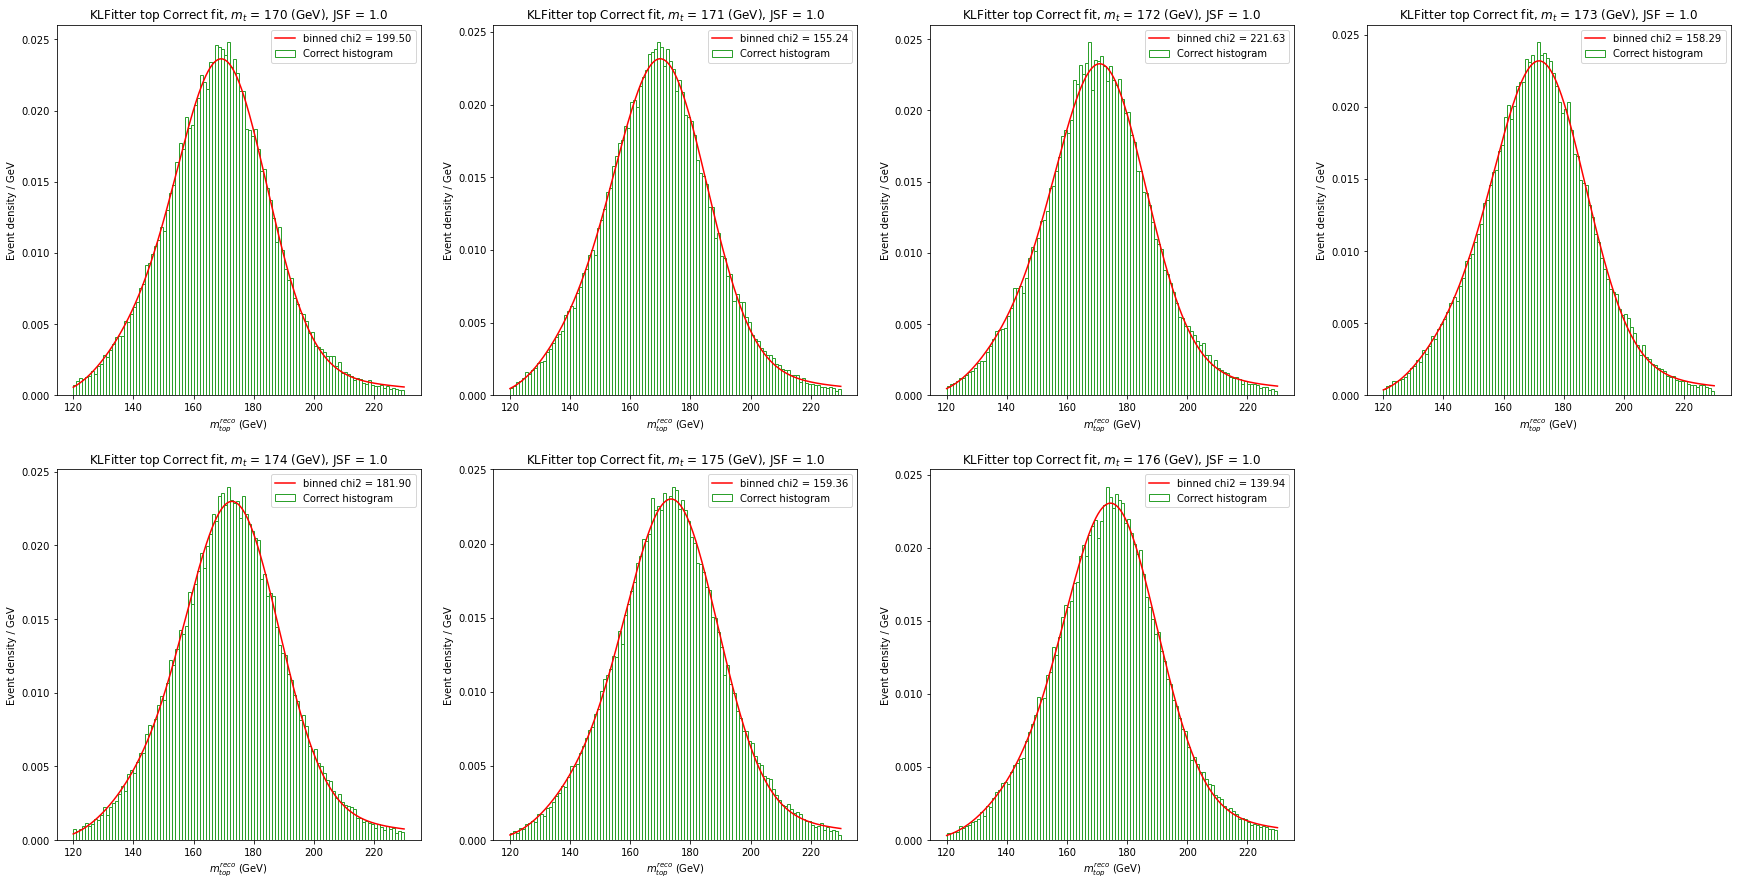

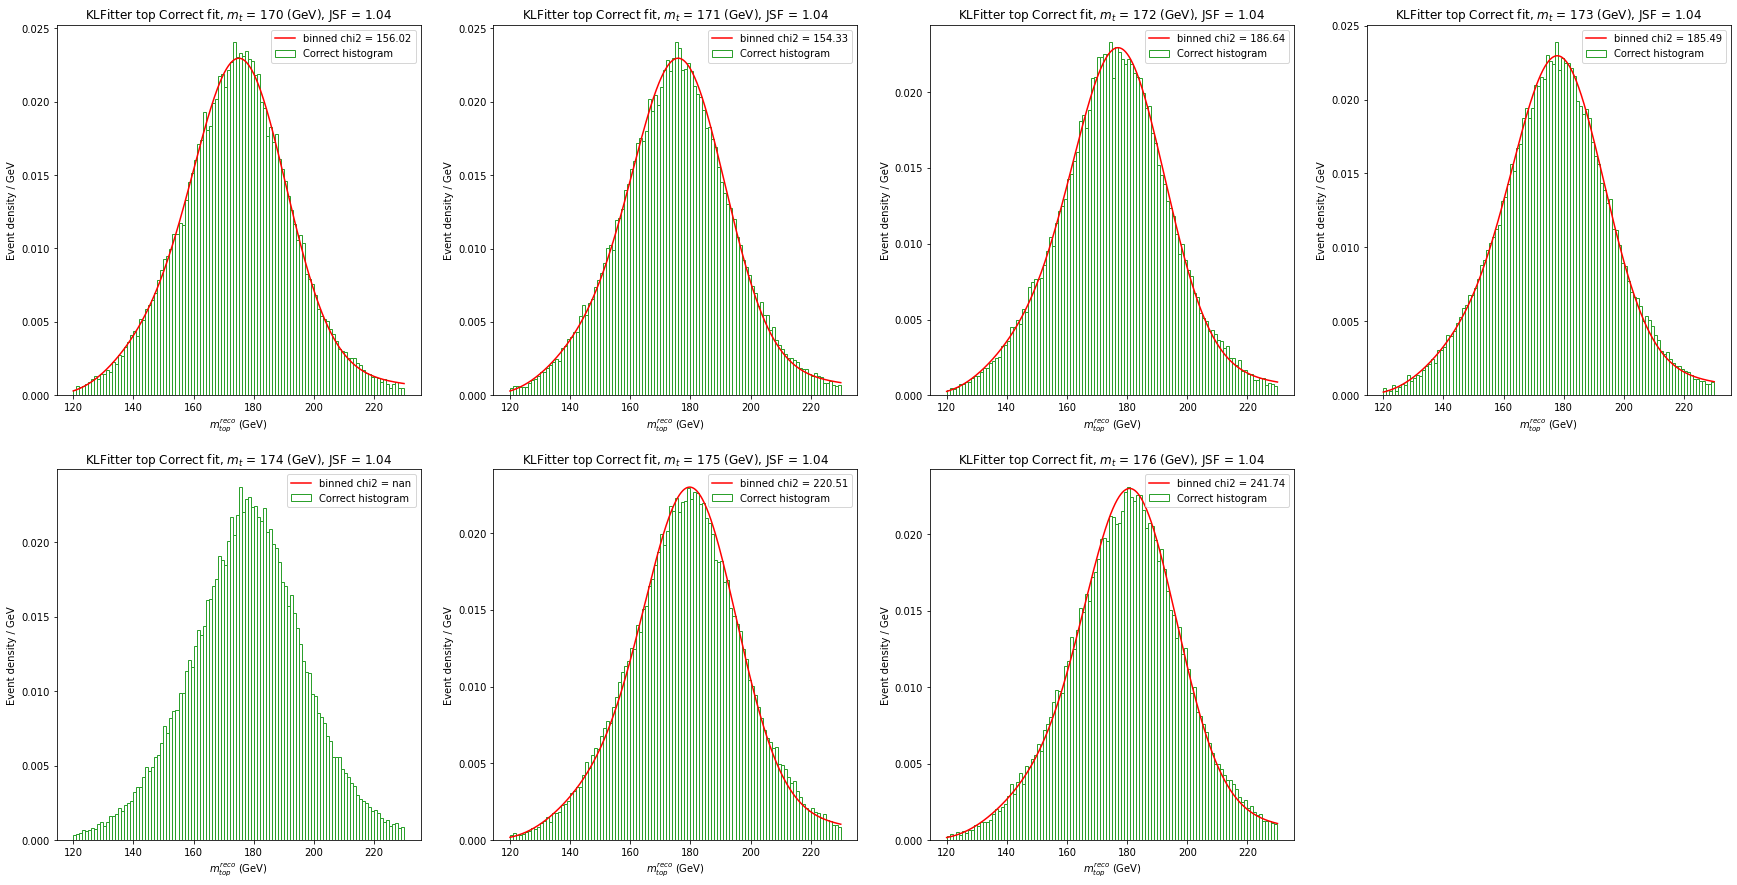

In [30]:
# Fit KLFitter reconstructed top mass for every state
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}
limits = {}
limits[0] = [(155, 180), (17, 23), (140, 170), (33, 38), (0.55, 0.55)]
limits[1] = [(120, 160), (12, 25), (155, 173), (12, 17.2), (0.12, 0.12)]
limits[2] = [(140, 162.5), (12.5, 20), (150, 200), (13, 15), (0.72, 0.72)]

for state_i in states:
    for JSF in JSF_arr:
        plt.figure(figsize=(30, 15))
        for i, m in enumerate(mass):
            plt.subplot(2, 4, i+1)
            fit_target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)]==state_i))]
            hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
            tot_event = len(fit_target)
            limit = limits[state_i]
            popt, errors = fit_function('top', limit)
            fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
            plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt)):.2f}')
            plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.title(f'KLFitter top {state_labels[state_i]} fit, $m_t$ = {m} (GeV), JSF = {JSF}')
            plt.xlabel('$m^{reco}_{top}$ (GeV)')
            plt.ylabel('Event density / GeV')
            plt.legend(loc='upper right')
        plt.show()

ValueError: array must not contain infs or NaNs

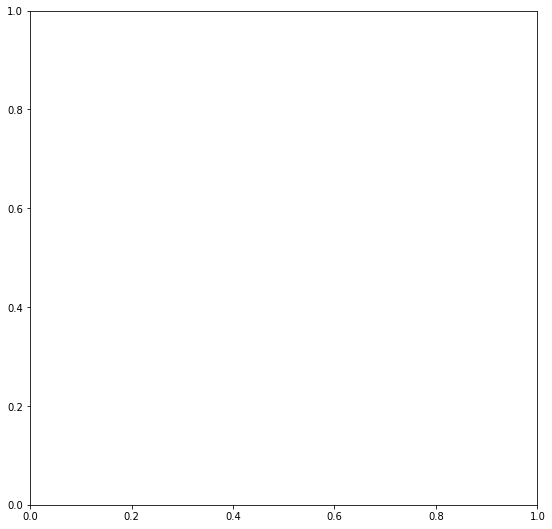

In [31]:
pdf_klf_top_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(20, 20))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        popt, pcov = optimize.curve_fit(linear_linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_klf_top_dic[(state_i, i)] = popt

        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label=f'JSF = {JSF}', c=colors[j])
            plt.plot(top_mass_dense, linear_linear([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title(f'KLFitter top PDF {state_labels[state_i]} parameters fit')
        plt.xlabel('$m_t$ (GeV)')
        plt.ylabel(langau_fit_labels[i])
    plt.show()
    pdf_klf_top_dic[(state_i, 4)] = np.array([limits[state_i][-1][0], 0, 1, 0])

In [ ]:
# Fit KLFitter reconstucted W mass for every state
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}
limits = {}
limits[0] = [(75, 90), (5, 10), (70, 90), (26, 32), (0.77, 0.77)]
limits[1] = [(70, 90), (5, 7.1), (70, 90), (20, 23), (0.45, 0.45)]
limits[2] = [(70, 90), (6.4, 8), (70, 90), (13, 15), (0.52, 0.52)]

for state_i in states:
    for JSF in JSF_arr:
        plt.figure(figsize=(30, 15))
        for i, m in enumerate(mass):
            plt.subplot(2, 4, i+1)
            fit_target = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)]==state_i))]
            hist, _ = np.histogram(fit_target, bins=W_bins, density=True)
            tot_event = len(fit_target)
            limit = limits[state_i]
            popt, errors = fit_function('W', limit)
            fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
            plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf_W(fit_target, two_gau_norm(W_bins_mid, *popt)):.2f}')
            plt.bar(W_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.title(f'KLFitter W {state_labels[state_i]} fit, $m_t$ = {m} (GeV), JSF = {JSF}')
            plt.xlabel('$m^{reco}_W$ (GeV)')
            plt.ylabel('Event density / GeV')
        #plt.savefig(f'plots_topmass_JSF/KLFitter_pdf_fit/KLFitter W {state_labels[state_i]} fit, JSF = {JSF}.png', bbox_inches='tight')
        plt.close()
np.savez(f'./top_mass_JSF_param/template_param{saving_index}/klf_W.npz',
            fit_popt_dic=fit_popt_dic,
            fit_perr_dic=fit_perr_dic)

In [ ]:
pdf_klf_W_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(20, 20))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        popt, pcov = optimize.curve_fit(linear_linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_klf_W_dic[(state_i, i)] = popt

        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label=f'JSF = {JSF}', c=colors[j])
            plt.plot(top_mass_dense, linear_linear([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.title(f'KLFitter W PDF {state_labels[state_i]} parameter')
        plt.xlabel('$m_t$ (GeV)')
        plt.ylabel(twogau_fit_labels[i])
        plt.legend(loc='upper right')
    #plt.savefig(f'plots_topmass_JSF/KLFitter_param_fit/KLFitter W {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.show()
    pdf_klf_W_dic[(state_i, 4)] = np.array([limits[state_i][-1][0], 0, 1, 0])


In [ ]:
# Fit PDNN reconstructed top mass for every state
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}
limits = {}
limits[0] = [(152, 175), (17.5, 22), (140, 200), (32, 36), (0.74, 0.74)]
limits[1] = [(160, 200), (10, 16), (150, 175), (20.5, 25), (0.77, 0.77)]
limits[2] = [(160, 200), (8.4, 9.2), (140, 178), (15, 19.5), (0.73, 0.73)]

for state_i in states:
    for JSF in JSF_arr:
        plt.figure(figsize=(30, 15))
        for i, m in enumerate(mass):
            plt.subplot(2, 4, i+1)
            fit_target = reco_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)], state_pdnn_dic[(m, JSF)]==state_i))]
            hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
            tot_event = len(fit_target)
            limit = limits[state_i]
            popt, errors = fit_function('top', limit)
            fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
            plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt)):.2f}')
            plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.title(f'PDNN top {state_labels[state_i]} fit, $m_t$ = {m} (GeV), JSF = {JSF}')
            plt.xlabel('$m^{reco}_{t}$ (GeV)')
            plt.ylabel('Event density / GeV')
            plt.legend(loc='upper right')
        #plt.savefig(f'plots_topmass_JSF/PDNN_pdf_fit/PDNN top {state_labels[state_i]} fit, JSF = {JSF}.png', bbox_inches='tight')
        plt.close()
np.savez(f'./top_mass_JSF_param/template_param{saving_index}/pdnn_top.npz',
            fit_popt_dic=fit_popt_dic,
            fit_perr_dic=fit_perr_dic)

In [ ]:
pdf_pdnn_top_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(20, 20))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        popt, pcov = optimize.curve_fit(linear_linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_pdnn_top_dic[(state_i, i)] = popt

        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label=f'JSF = {JSF}', c=colors[j])
            plt.plot(top_mass_dense, linear_linear([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title(f'PDNN top PDF {state_labels[state_i]} parameters with errobar')
        plt.xlabel('$m_t$ (GeV)')
        plt.ylabel(langau_fit_labels[i])
        plt.legend(loc='upper right')
    #plt.savefig(f'plots_topmass_JSF/PDNN_param_fit/PDNN top {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.show()
    pdf_pdnn_top_dic[(state_i, 4)] = np.array([limits[state_i][-1][0], 0, 1, 0])
    

In [ ]:
# Fit PDNN reconstucted W mass for every state
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}
limits = {}
limits[0] = [(70, 90), (5, 21), (80, 95), (27, 40), (0.50, 0.50)]
limits[1] = [(70, 90), (5, 15), (70, 90), (18, 25), (0.50, 0.50)]
limits[2] = [(70, 90), (5, 9), (79, 90), (14, 15), (0.55, 0.55)]

for state_i in states:
    for JSF in JSF_arr:
        plt.figure(figsize=(30, 15))
        for i, m in enumerate(mass):
            plt.subplot(2, 4, i+1)
            fit_target = W_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)], state_pdnn_dic[(m, JSF)]==state_i))]
            hist, _ = np.histogram(fit_target, bins=W_bins, density=True)
            tot_event = len(fit_target)
            limit = limits[state_i]
            popt, errors = fit_function('W', limit)
            fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
            plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf_W(fit_target, two_gau_norm(W_bins_mid, *popt)):.2f}')
            plt.bar(W_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.title(f'PDNN W {state_labels[state_i]} fit, $m_t$ = {m} (GeV), JSF = {JSF}')
            plt.xlabel('$m^{reco}_W$ (GeV)')
            plt.ylabel('Event density / GeV')
            plt.legend(loc='upper right')
        #plt.savefig(f'plots_topmass_JSF/PDNN_pdf_fit/PDNN W {state_labels[state_i]} fit, JSF = {JSF}.png', bbox_inches='tight')
        plt.close()
np.savez(f'./top_mass_JSF_param/template_param{saving_index}/pdnn_W.npz',
            fit_popt_dic=fit_popt_dic,
            fit_perr_dic=fit_perr_dic)

In [ ]:
pdf_pdnn_W_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(20, 20))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        popt, pcov = optimize.curve_fit(linear_linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_pdnn_W_dic[(state_i, i)] = popt

        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label=f'JSF = {JSF}', c=colors[j])
            plt.plot(top_mass_dense, linear_linear([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.title(f'PDNN W PDF {state_labels[state_i]} parameters fit')
        plt.xlabel('$m_t$ (GeV)')
        plt.ylabel(twogau_fit_labels[i])
        plt.legend(loc='upper right')
    #plt.savefig(f'plots_topmass_JSF/PDNN_param_fit/PDNN W {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.show()
    pdf_pdnn_W_dic[(state_i, 4)] = np.array([limits[state_i][-1][0], 0, 1, 0])


In [ ]:
# Fit SPANet reconstructed top mass for every state
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}
limits = {}
limits[0] = [(140, 165), (5, 17), (140, 200), (23, 30), (0.75, 0.75)]
limits[1] = [(140, 170), (5, 25), (140, 200), (5, 50), (0.88, 0.88)]
limits[2] = [(160, 200), (6, 10), (140, 200), (5, 20), (0.78, 0.78)]

for state_i in states:
    for JSF in JSF_arr:
        plt.figure(figsize=(30, 15))
        for i, m in enumerate(mass):
            plt.subplot(2, 4, i+1)
            fit_target = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)] == state_i, likeli_spanet_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
            tot_event = len(fit_target)
            limit = limits[state_i]
            popt, errors = fit_function('top', limit)
            fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
            plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt))))
            plt.title(f'SPANet top {state_labels[state_i]} fit, $m_t$ = {m} (GeV), JSF = {JSF}')
            plt.xlabel('$m^{reco}_{top}$ (GeV)')
            plt.ylabel('Event density / GeV')
            plt.legend(loc = 'upper right')
        #plt.savefig(f'plots_topmass_JSF/SPANet_pdf_fit/SPANet top {state_labels[state_i]} fit, JSF = {JSF}.png', bbox_inches='tight')
        plt.close()
np.savez(f'./top_mass_JSF_param/template_param{saving_index}/spanet_top.npz',
            fit_popt_dic=fit_popt_dic,
            fit_perr_dic=fit_perr_dic)

In [ ]:
pdf_spanet_top_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(20, 20))
    plt.rcParams.update({'font.size': 18})
    for i in range(4):
        plt.subplot(2, 2, i+1)
        popt, pcov = optimize.curve_fit(linear_linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_spanet_top_dic[(state_i, i)] = popt
        
        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label= f'JSF = {JSF}', c=colors[j])
            plt.plot(top_mass_dense, linear_linear([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title(f'SPANet top PDF {state_labels[state_i]} parameters')
        plt.xlabel('$m_t$ (GeV)')
        plt.ylabel(langau_fit_labels[i])
    #plt.savefig(f'plots_topmass_JSF/SPANet_param_fit/SPANet top {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.show()
    pdf_spanet_top_dic[(state_i, 4)] = np.array([limits[state_i][-1][0], 0, 1, 0])


In [ ]:
# Fit SPANet reconstucted W mass for every state
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}
limits = {}
limits[0] = [(50, 75), (5, 12), (50, 100), (5, 20), (0.60, 0.60)]
limits[1] = [(50, 100), (5, 50), (50, 84), (4.5, 7), (0.06, 0.06)]
limits[2] = [(70, 85), (5, 8), (78, 100), (12.5, 20), (0.55, 0.55)]

for state_i in states:
    for JSF in JSF_arr:
        plt.figure(figsize=(30, 15))
        for i, m in enumerate(mass):
            plt.subplot(2, 4, i+1)
            fit_target = W_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)] == state_i, likeli_spanet_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=W_bins, density=True)
            tot_event = len(fit_target)
            limit = limits[state_i]
            popt, errors = fit_function('W', limit)
            fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
            plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt), c='r', label='binned chi2 = {:.2f}'.format(chi2_pdf_W(fit_target, two_gau_norm(W_bins_mid, *popt))))
            plt.bar(W_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.title(f'SPANet W {state_labels[state_i]} fit, $m_t$ = {m} (GeV), JSF = {JSF}')
            plt.xlabel('$m^{reco}_W$ (GeV)')
            plt.ylabel('Event density / GeV')
            plt.legend(loc='upper right')
        #plt.savefig(f'plots_topmass_JSF/SPANet_pdf_fit/SPANet W {state_labels[state_i]} fit, JSF = {JSF}.png', bbox_inches='tight')
        plt.close()
np.savez(f'./top_mass_JSF_param/template_param{saving_index}/spanet_W.npz',
            fit_popt_dic=fit_popt_dic,
            fit_perr_dic=fit_perr_dic)

In [ ]:
pdf_spanet_W_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(20, 20))
    plt.rcParams.update({'font.size': 18})
    for i in range(4):
        plt.subplot(2, 2, i+1)
        popt, pcov = optimize.curve_fit(linear_linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_spanet_W_dic[(state_i, i)] = popt
        
        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label= f'JSF = {JSF}', c=colors[j])
            plt.plot(top_mass_dense, linear_linear([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title(f'SPANet W PDF {state_labels[state_i]} parameters')
        plt.xlabel('$m_t$ (GeV)')
        plt.ylabel(twogau_fit_labels[i])
    #plt.savefig(f'plots_topmass_JSF/SPANet_param_fit/SPANet W {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.show()
    pdf_spanet_W_dic[(state_i, 4)] = np.array([limits[state_i][-1][0], 0, 1, 0])


In [ ]:
# Fit Perfect reconstructed top mass
fit_popt_dic = {i:{} for i in [2]}
fit_perr_dic = {i:{} for i in [2]}

for JSF in JSF_arr:
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)]==2))]
        hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
        tot_event = len(fit_target)
        limit = [(160, 200), (9, 10), (130, 200), (10, 25), (0.70, 0.70)]
        popt, errors = fit_function('top', limit)
        fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
        plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt))))
        plt.title(f'Perfect top fit, $m_t$ = {m} (GeV), JSF = {JSF}')
        plt.xlabel('$m^{reco}_{top}$ (GeV)')
        plt.ylabel('Event density / GeV')
        plt.legend(loc = 'upper right')
    #plt.savefig(f'plots_topmass_JSF/Perfect_pdf_fit/Perfect top fit, JSF = {JSF}.png', bbox_inches='tight')
    plt.close()
np.savez(f'./top_mass_JSF_param/template_param{saving_index}/perfect_top.npz',
            fit_popt_dic=fit_popt_dic,
            fit_perr_dic=fit_perr_dic)

In [ ]:
pdf_perfect_top_dic = defaultdict(list)
state_i = 2
plt.figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(2, 2, i+1)
    popt, pcov = optimize.curve_fit(linear_linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
    pdf_perfect_top_dic[(state_i, i)] = popt

    for j, JSF in enumerate(JSF_arr):
        plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label= f'JSF = {JSF}', c=colors[j])
        plt.plot(top_mass_dense, linear_linear([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
    plt.legend(loc='upper right')
    plt.title(f'Perfect top PDF {state_labels[state_i]} parameters')
    plt.xlabel('$m_t$ (GeV)')
    plt.ylabel(langau_fit_labels[i])
#plt.savefig(f'plots_topmass_JSF/Perfect_param_fit/Perfect top fit.png', bbox_inches='tight')
plt.show()
pdf_perfect_top_dic[(state_i, 4)] = np.array([limit[-1][0], 0, 1, 0])


In [ ]:
# Fit Perfect reconstucted W mass
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}

for JSF in JSF_arr:
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = W_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)]==2))]
        hist, _ = np.histogram(fit_target, bins=W_bins, density=True)
        tot_event = len(fit_target)
        limit = [(50, 90), (5, 9), (60, 90), (13, 20), (0.53, 0.53)]
        popt, errors = fit_function('W', limit)
        fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
        plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt), c='r', label='binned chi2 = {:.2f}'.format(chi2_pdf_W(fit_target, two_gau_norm(W_bins_mid, *popt))))
        plt.bar(W_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
        plt.title(f'Perfect W fit, $m_t$ = {m} (GeV), JSF = {JSF}')
        plt.xlabel('$m^{reco}_W$ (GeV)')
        plt.ylabel('Event density / GeV')
        plt.legend(loc='upper right')
    #plt.savefig(f'plots_topmass_JSF/Perfect_pdf_fit/Perfect W fit, JSF = {JSF}.png', bbox_inches='tight')
    plt.close()
np.savez(f'./top_mass_JSF_param/template_param{saving_index}/perfect_W.npz',
            fit_popt_dic=fit_popt_dic,
            fit_perr_dic=fit_perr_dic)

In [ ]:
pdf_perfect_W_dic = defaultdict(list)
for state_i in [2]:
    plt.figure(figsize=(20, 20))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        popt, pcov = optimize.curve_fit(linear_linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_perfect_W_dic[(state_i, i)] = popt
        
        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label= f'JSF = {JSF}', c=colors[j])
            plt.plot(top_mass_dense, linear_linear([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title(f'Perfect W PDF {state_labels[state_i]} parameters')
        plt.xlabel('$m_t$ (GeV)')
        plt.ylabel(langau_fit_labels[i])
    #plt.savefig(f'plots_topmass_JSF/Perfect_param_fit/Perfect W fit.png', bbox_inches='tight')
    plt.show()
    pdf_perfect_W_dic[(state_i, 4)] = np.array([limit[-1][0], 0, 1, 0])


In [ ]:
# Compare the KLFitter reconstructed top mass pdf to the original template
for state_i in states:
    for JSF in JSF_arr:
        plt.figure(figsize=(30, 15))
        for i, m in enumerate(mass):
            plt.subplot(2, 4, i+1)
            fit_target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)] == state_i, likeli_klf_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
            popt = [linear_linear((m, JSF), *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
            plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt))))
            plt.title(f'KLFitter {state_labels[state_i]} comparison, $m_t$ = {m} (GeV), JSF = {JSF}')
            plt.xlabel('$m^{reco}_{top}$ (GeV)')
            plt.ylabel('Event density / GeV')
            plt.legend(loc = 'upper right')
        #plt.savefig(f'plots_topmass_JSF/KLFitter_pdf_compare/KLFitter top {state_labels[state_i]} compare, JSF = {JSF}.png', bbox_inches='tight')
        plt.close()


In [ ]:
# Compare the KLFitter reconstructed W mass pdf to the original template
for state_i in states:
    for JSF in JSF_arr:
        plt.figure(figsize=(30, 15))
        for i, m in enumerate(mass):
            plt.subplot(2, 4, i+1)
            fit_target = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)] == state_i, likeli_klf_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=W_bins, density=True)
            popt = [linear_linear((m, JSF), *pdf_klf_W_dic[(state_i, j)]) for j in range(5)]
            plt.bar(W_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_W(fit_target, two_gau_norm(W_bins_mid, *popt))))
            plt.title(f'KLFitter {state_labels[state_i]} comparison, $m_t$ = {m} (GeV), JSF = {JSF}')
            plt.xlabel('$m^{reco}_W$ (GeV)')
            plt.ylabel('Event density / GeV')
            plt.legend(loc = 'upper right')
        #plt.savefig(f'plots_topmass_JSF/KLFitter_pdf_compare/KLFitter W {state_labels[state_i]} compare, JSF = {JSF}.png', bbox_inches='tight')
        plt.close()


In [ ]:
# Compare the PDNN reconstructed top mass pdf to the original template
for state_i in states:
    for JSF in JSF_arr:
        plt.figure(figsize=(30, 15))
        for i, m in enumerate(mass):
            plt.subplot(2, 4, i+1)
            fit_target = reco_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], state_pdnn_dic[(m, JSF)] == state_i, likeli_pdnn_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
            popt = [linear_linear((m, JSF), *pdf_pdnn_top_dic[(state_i, j)]) for j in range(5)]
            plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt))))
            plt.title(f'PDNN {state_labels[state_i]} comparison, $m_t$ = {m} (GeV), JSF = {JSF}')
            plt.xlabel('$m^{reco}_{top}$ (GeV)')
            plt.ylabel('Event density / GeV')
            plt.legend(loc = 'upper right')
        #plt.savefig(f'plots_topmass_JSF/PDNN_pdf_compare/PDNN top {state_labels[state_i]} compare, JSF = {JSF}.png', bbox_inches='tight')
        plt.close()


In [ ]:
# Compare the PDNN reconstructed W mass pdf to the original template
for state_i in states:
    for JSF in JSF_arr:
        plt.figure(figsize=(30, 15))
        for i, m in enumerate(mass):
            plt.subplot(2, 4, i+1)
            fit_target = W_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], state_pdnn_dic[(m, JSF)] == state_i, likeli_pdnn_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=W_bins, density=True)
            popt = [linear_linear((m, JSF), *pdf_pdnn_W_dic[(state_i, j)]) for j in range(5)]
            plt.bar(W_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_W(fit_target, two_gau_norm(W_bins_mid, *popt))))
            plt.title(f'PDNN {state_labels[state_i]} comparison, $m_t$ = {m} (GeV), JSF = {JSF}')
            plt.xlabel('$m^{reco}_{W}$ (GeV)')
            plt.ylabel('Event density / GeV')
            plt.legend(loc = 'upper right')
        #plt.savefig(f'plots_topmass_JSF/PDNN_pdf_compare/PDNN W {state_labels[state_i]} compare, JSF = {JSF}.png', bbox_inches='tight')
        plt.close()


In [ ]:
# Compare the SPANet reconstructed top mass pdf to the original template
for state_i in states:
    for JSF in JSF_arr:
        plt.figure(figsize=(30,15))
        for i, m in enumerate(mass):
            plt.subplot(2, 4, i+1)
            fit_target = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)] == state_i, likeli_spanet_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
            popt = [linear_linear((m, JSF), *pdf_spanet_top_dic[(state_i, j)]) for j in range(5)]
            plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt))))
            plt.title(f'SPANet {state_labels[state_i]} comparison, $m_t$ = {m} (GeV), JSF = {JSF}')
            plt.xlabel('$m^{reco}_{top}$ (GeV)')
            plt.ylabel('Event density / GeV')
            plt.legend(loc = 'upper right')
        #plt.savefig(f'plots_topmass_JSF/SPANet_pdf_compare/SPANet top {state_labels[state_i]} compare, JSF = {JSF}.png', bbox_inches='tight')
        plt.close()


In [ ]:
# Compare the SPANet reconstructed W mass pdf to the original template
for state_i in states:
    for JSF in JSF_arr:
        plt.figure(figsize=(30, 15))
        for i, m in enumerate(mass):
            plt.subplot(2, 4, i+1)
            fit_target = W_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)] == state_i, likeli_spanet_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=W_bins, density=True)
            popt = [linear_linear((m, JSF), *pdf_spanet_W_dic[(state_i, j)]) for j in range(5)]
            plt.bar(W_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_W(fit_target, two_gau_norm(W_bins_mid, *popt))))
            plt.title(f'SPANet W {state_labels[state_i]} comparison, $m_t$ = {m} (GeV), JSF = {JSF}')
            plt.xlabel('$m^{reco}_{W}$ (GeV)')
            plt.ylabel('Event density / GeV')
            plt.legend(loc = 'upper right')
        #plt.savefig(f'plots_topmass_JSF/SPANet_pdf_compare/SPANet W {state_labels[state_i]} compare, JSF = {JSF}.png', bbox_inches='tight')
        plt.close()


In [ ]:
# Compare the Perfect reconstructed top mass pdf to the original template
for JSF in JSF_arr:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)] == 2))]
        hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
        popt = [linear_linear((m, JSF), *pdf_perfect_top_dic[(state_i, j)]) for j in range(5)]
        plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt))))
        plt.title(f'Perfect comparison, $m_t$ = {m} (GeV), JSF = {JSF}')
        plt.xlabel('$m^{reco}_{top}$ (GeV)')
        plt.ylabel('Event density / GeV')
        plt.legend(loc = 'upper right')
    #plt.savefig(f'plots_topmass_JSF/Perfect_pdf_compare/Perfect top compare, JSF = {JSF}.png', bbox_inches='tight')
    plt.close()

In [ ]:
# Compare the Perfect reconstructed W mass pdf to the original template
for JSF in JSF_arr:
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = W_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)] == 2))]
        hist, _ = np.histogram(fit_target, bins=W_bins, density=True)
        popt = [linear_linear((m, JSF), *pdf_perfect_W_dic[(state_i, j)]) for j in range(5)]
        plt.bar(W_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_W(fit_target, two_gau_norm(W_bins_mid, *popt))))
        plt.title(f'Perfect comparison, $m_t$ = {m} (GeV), JSF = {JSF}')
        plt.xlabel('$m^{reco}_{W}$ (GeV)')
        plt.ylabel('Event density / GeV')
        plt.legend(loc = 'upper right')
    #plt.savefig(f'plots_topmass_JSF/Perfect_pdf_compare/Perfect W compare, JSF = {JSF}.png', bbox_inches='tight')
    plt.close()

In [33]:
def klf_top_pdf_func(x, m, JSF):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear_linear((m, JSF), *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
        hist += langau_norm(x, *popt)*linear_parabola([m, JSF], *fpdf_klf_popt[state_i])
    return hist

def klf_W_pdf_func(x, m, JSF):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear_linear((m, JSF), *pdf_klf_W_dic[(state_i, j)]) for j in range(5)]
        hist += two_gau_norm(x, *popt)*linear_parabola([m, JSF], *fpdf_klf_popt[state_i])
    return hist

def pdnn_top_pdf_func(x, m, JSF):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear_linear((m, JSF), *pdf_pdnn_top_dic[(state_i, j)]) for j in range(5)]
        hist += langau_norm(x, *popt)*linear_parabola([m, JSF], *fpdf_pdnn_popt[state_i])
    return hist

def pdnn_W_pdf_func(x, m, JSF):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear_linear((m, JSF), *pdf_pdnn_W_dic[(state_i, j)]) for j in range(5)]
        hist += two_gau_norm(x, *popt)*linear_parabola([m, JSF], *fpdf_pdnn_popt[state_i])
    return hist

def spanet_top_pdf_func(x, m, JSF):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear_linear((m, JSF), *pdf_spanet_top_dic[(state_i, j)]) for j in range(5)]
        hist += langau_norm(x, *popt)*linear_parabola([m, JSF], *fpdf_spanet_popt[state_i])
    return hist

def spanet_W_pdf_func(x, m, JSF):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear_linear((m, JSF), *pdf_spanet_W_dic[(state_i, j)]) for j in range(5)]
        hist += two_gau_norm(x, *popt)*linear_parabola([m, JSF], *fpdf_spanet_popt[state_i])
    return hist

def perfect_top_pdf_func(x, m, JSF):
    popt = [linear_linear((m, JSF), *pdf_perfect_top_dic[(2, j)]) for j in range(5)]
    return langau_norm(x, *popt)

def perfect_W_pdf_func(x, m, JSF):
    popt = [linear_linear((m, JSF), *pdf_perfect_W_dic[(2, j)]) for j in range(5)]
    return two_gau_norm(x, *popt)


NameError: name 'fpdf_klf_popt' is not defined

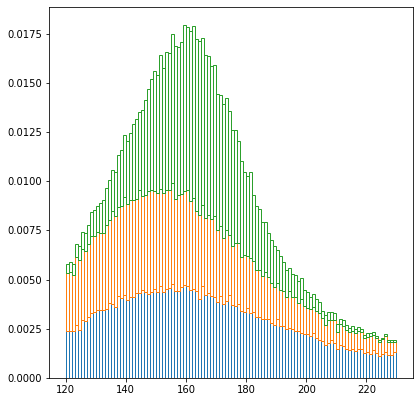

In [34]:
# Compare the KLFitter top pdf to the template histogram
for JSF in JSF_arr:
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]        
        h, tot = [0]*(len(top_bins)-1), len(target)
        for state_i in states:
            hist, _ = np.histogram(reco_klf_dic[(m, JSF)][np.logical_and.reduce((state_klf_dic[(m, JSF)] == state_i, cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))], bins=top_bins)
            plt.bar(top_bins_mid, hist/tot/bins_width, bottom=h, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            h += hist/tot/bins_width

        plt.plot(top_bins_dense, klf_top_pdf_func(top_bins_dense, m, JSF), c='r')
        plt.title(f'KLFitter top pdf comparison, $m_t$ = {m} (GeV), JSF = {JSF}')
        plt.xlabel('$m^{reco}_{top}$ (GeV)')
        plt.ylabel('Event density / GeV')
        plt.legend(loc='upper right')
    #plt.savefig(f'plots_topmass_JSF/KLFitter_pdf_compare/KLFitter top pdf compare, JSF = {JSF}.png', bbox_inches='tight')
    plt.close()
    

In [ ]:
# Compare the KLFitter W pdf to the template histogram
for JSF in JSF_arr:
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]        
        h, tot = [0]*(len(W_bins)-1), len(target)
        for state_i in states:
            hist, _ = np.histogram(W_klf_dic[(m, JSF)][np.logical_and.reduce((state_klf_dic[(m, JSF)] == state_i, cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))], bins=W_bins)
            plt.bar(W_bins_mid, hist/tot/bins_width, bottom=h, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            h += hist/tot/bins_width

        plt.plot(W_bins_dense, klf_W_pdf_func(W_bins_dense, m, JSF), c='r')
        plt.title(f'KLFitter W pdf comparison, $m_t$ = {m} (GeV), JSF = {JSF}')
        plt.xlabel('$m^{reco}_{W}$ (GeV)')
        plt.ylabel('Event density / GeV')
        plt.legend(loc='upper right')
    #plt.savefig(f'plots_topmass_JSF/KLFitter_pdf_compare/KLFitter W pdf compare, JSF = {JSF}.png', bbox_inches='tight')
    plt.close()


In [ ]:
# Compare the PDNN top pdf to the template histogram
for JSF in JSF_arr:
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = reco_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)]))]        
        h, tot = [0]*(len(top_bins)-1), len(target)
        for state_i in states:
            hist, _ = np.histogram(reco_pdnn_dic[(m, JSF)][np.logical_and.reduce((state_pdnn_dic[(m, JSF)] == state_i, cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)]))], bins=top_bins)
            plt.bar(top_bins_mid, hist/tot/bins_width, bottom=h, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            h += hist/tot/bins_width

        plt.plot(top_bins_dense, pdnn_top_pdf_func(top_bins_dense, m, JSF), c='r')
        plt.title(f'PDNN top pdf comparison, $m_t$ = {m} (GeV), JSF = {JSF}')
        plt.xlabel('$m^{reco}_{top}$ (GeV)')
        plt.ylabel('Event density / GeV')
        plt.legend(loc='upper right')
    #plt.savefig(f'plots_topmass_JSF/PDNN_pdf_compare/PDNN top pdf compare, JSF = {JSF}.png', bbox_inches='tight')
    plt.close()
    

In [ ]:
# Compare the PDNN W pdf to the template histogram
for JSF in JSF_arr:
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = W_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)]))]        
        h, tot = [0]*(len(W_bins)-1), len(target)
        for state_i in states:
            hist, _ = np.histogram(W_pdnn_dic[(m, JSF)][np.logical_and.reduce((state_pdnn_dic[(m, JSF)] == state_i, cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)]))], bins=W_bins)
            plt.bar(W_bins_mid, hist/tot/bins_width, bottom=h, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            h += hist/tot/bins_width

        plt.plot(W_bins_dense, pdnn_W_pdf_func(W_bins_dense, m, JSF), c='r')
        plt.title(f'PDNN W pdf comparison, $m_t$ = {m} (GeV), JSF = {JSF}')
        plt.xlabel('$m^{reco}_{W}$ (GeV)')
        plt.ylabel('Event density / GeV')
        plt.legend(loc='upper right')
    #plt.savefig(f'plots_topmass_JSF/PDNN_pdf_compare/PDNN W pdf compare, JSF = {JSF}.png', bbox_inches='tight')
    plt.close()


In [ ]:
# Compare the SPANet top pdf to the template histogram
for JSF in JSF_arr:
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]        
        h, tot = [0]*(len(top_bins)-1), len(target)
        for state_i in states:
            hist, _ = np.histogram(reco_spanet_dic[(m, JSF)][np.logical_and.reduce((state_spanet_dic[(m, JSF)] == state_i, cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))], bins=top_bins)
            plt.bar(top_bins_mid, hist/tot/bins_width, bottom=h, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            h += hist/tot/bins_width

        plt.plot(top_bins_dense, spanet_top_pdf_func(top_bins_dense, m, JSF), c='r')
        plt.title(f'SPANet top pdf comparison, $m_t$ = {m} (GeV), JSF = {JSF}')
        plt.xlabel('$m^{reco}_{top}$ (GeV)')
        plt.ylabel('Event density / GeV')
        plt.legend(loc='upper right')
    #plt.savefig(f'plots_topmass_JSF/SPANet_pdf_compare/SPANet top pdf compare, JSF = {JSF}.png', bbox_inches='tight')
    plt.close()
    

In [ ]:
# Compare the SPANet W pdf to the template histogram
for JSF in JSF_arr:
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = W_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]        
        h, tot = [0]*(len(W_bins)-1), len(target)
        for state_i in states:
            hist, _ = np.histogram(W_spanet_dic[(m, JSF)][np.logical_and.reduce((state_spanet_dic[(m, JSF)] == state_i, cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))], bins=W_bins)
            plt.bar(W_bins_mid, hist/tot/bins_width, bottom=h, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            h += hist/tot/bins_width

        plt.plot(W_bins_dense, spanet_W_pdf_func(W_bins_dense, m, JSF), c='r')
        plt.title(f'SPANet W pdf comparison, $m_t$ = {m} (GeV), JSF = {JSF}')
        plt.xlabel('$m^{reco}_{W}$ (GeV)')
        plt.ylabel('Event density / GeV')
        plt.legend(loc='upper right')
    #plt.savefig(f'plots_topmass_JSF/SPANet_pdf_compare/SPANet W pdf compare, JSF = {JSF}.png', bbox_inches='tight')
    plt.close()


In [ ]:
np.savez(f'./top_mass_JSF_param/params_topmass_JSF{saving_index}.npz',
         pdf_klf_top_dic=pdf_klf_top_dic, pdf_klf_W_dic=pdf_klf_W_dic,
         pdf_pdnn_top_dic=pdf_pdnn_top_dic, pdf_pdnn_W_dic=pdf_pdnn_W_dic,
         pdf_spanet_top_dic=pdf_spanet_top_dic, pdf_spanet_W_dic=pdf_spanet_W_dic,
         pdf_perfect_top_dic=pdf_perfect_top_dic, pdf_perfect_W_dic=pdf_perfect_W_dic)


In [32]:
data = np.load(f'./top_mass_JSF_param/params_topmass_JSF8.npz', allow_pickle=True)
pdf_klf_top_dic = data['pdf_klf_top_dic'].item()
pdf_klf_W_dic = data['pdf_klf_W_dic'].item()
pdf_pdnn_top_dic = data['pdf_pdnn_top_dic'].item()
pdf_pdnn_W_dic = data['pdf_pdnn_W_dic'].item()
pdf_spanet_top_dic = data['pdf_spanet_top_dic'].item()
pdf_spanet_W_dic = data['pdf_spanet_W_dic'].item()
pdf_perfect_top_dic = data['pdf_perfect_top_dic'].item()
pdf_perfect_W_dic = data['pdf_perfect_W_dic'].item()


In [52]:
# Define the dictionary storing the result of pseudo experiment
pseudo_klf_top_mean_dic = {}
pseudo_klf_top_std_dic = {}
pseudo_klf_JSF_mean_dic = {}
pseudo_klf_JSF_std_dic = {}

pseudo_pdnn_top_mean_dic = {}
pseudo_pdnn_top_std_dic = {}
pseudo_pdnn_JSF_mean_dic = {}
pseudo_pdnn_JSF_std_dic = {}

pseudo_spanet_top_mean_dic = {}
pseudo_spanet_top_std_dic = {}
pseudo_spanet_JSF_mean_dic = {}
pseudo_spanet_JSF_std_dic = {}

pseudo_perfect_top_mean_dic = {}
pseudo_perfect_top_std_dic = {}
pseudo_perfect_JSF_mean_dic = {}
pseudo_perfect_JSF_std_dic = {}

In [ ]:
# Pseudo experiment for KLFitter
for m, JSF in tqdm(product(mass, JSF_arr), total=len(mass)*len(JSF_arr)):
    if (m, JSF) not in pseudo_klf_top_mean_dic:
        reco_klf_top = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]
        reco_klf_W = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]
        pseudo_klf_top = np.histogram(reco_klf_top, bins=top_bins)[0]
        pseudo_klf_W = np.histogram(reco_klf_W, bins=W_bins)[0]
        n1_arr = np.random.poisson(pseudo_klf_top, size=(pseudo_event, len(pseudo_klf_top)))
        n2_arr = np.random.poisson(pseudo_klf_W, size=(pseudo_event, len(pseudo_klf_W)))
        def minimize_chi2(i):
            chi2_klf_arr_fcn = lambda m, JSF: -2*np.sum(n1_arr[i]*np.log(klf_top_pdf_func(top_bins_mid, m, JSF)*sum(n1_arr[i])*bins_width))\
            -2*np.sum(n2_arr[i]*np.log(klf_W_pdf_func(W_bins_mid, m, JSF)*sum(n2_arr[i])*bins_width))
            minuit = Minuit(chi2_klf_arr_fcn, m=173, JSF=1)
            minuit.limits = [[160, 186],[0.93, 1.07]]
            minuit.migrad()
            minuit.minos()
            return list(minuit.values), list(minuit.errors)
        with Pool() as pool:
            results = []
            for i in range(pseudo_event):
                results.append(pool.apply_async(minimize_chi2, args=((i,))))

            mean, std = [], []
            for result in results:
                res = result.get()
                mean.append(res[0])
                std.append(res[1])
            top_mean, JSF_mean = np.transpose(mean)
            top_std, JSF_std = np.transpose(std)
            pseudo_klf_top_mean_dic[(m, JSF)] = top_mean
            pseudo_klf_top_std_dic[(m, JSF)] = top_std
            pseudo_klf_JSF_mean_dic[(m, JSF)] = JSF_mean
            pseudo_klf_JSF_std_dic[(m, JSF)] = JSF_std
            results.clear()


 29%|███████████████████████████████████▍                                                                                        | 6/21 [2:54:47<7:14:05, 1736.37s/it]/tmp/ipykernel_9413/2057602661.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, top_bins_min, top_bins_max, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]
/tmp/ipykernel_9413/2057602661.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f)/integrate.quad(two_gau, W_bins_min, W_bins_max, args=(gau_loc1, gau_scale1, gau_loc2, gau_scale2, f))[0]
/tmp/ipykernel_9413/2057602661.py:9: IntegrationWarning: The occurrence of roundoff error

/tmp/ipykernel_9413/2057602661.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, top_bins_min, top_bins_max, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]
/tmp/ipykernel_9413/2057602661.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f)/integrate.quad(two_gau, W_bins_min, W_bins_max, args=(gau_loc1, gau_scale1, gau_loc2, gau_scale2, f))[0]
/tmp/ipykernel_9413/2057602661.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return langau(x, lan_loc, lan_scale, gau_loc, gau_

In [ ]:
# pseudo experiment for PDNN
for m, JSF in tqdm(product(mass, JSF_arr), total=len(mass)*len(JSF_arr)):
    if (m, JSF) not in pseudo_pdnn_top_mean_dic:
        reco_pdnn_top = reco_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)]))]
        reco_pdnn_W = W_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)]))]
        pseudo_pdnn_top = np.histogram(reco_pdnn_top, bins=top_bins)[0]
        pseudo_pdnn_W = np.histogram(reco_pdnn_W, bins=W_bins)[0]
        n1_arr = np.random.poisson(pseudo_pdnn_top, size=(pseudo_event, len(pseudo_pdnn_top)))
        n2_arr = np.random.poisson(pseudo_pdnn_W, size=(pseudo_event, len(pseudo_pdnn_W)))
        def minimize_chi2(i):
            chi2_pdnn_arr_fcn = lambda m, JSF: -2*np.sum(n1_arr[i]*np.log(pdnn_top_pdf_func(top_bins_mid, m, JSF)*sum(n1_arr[i])*bins_width))\
            -2*np.sum(n2_arr[i]*np.log(pdnn_W_pdf_func(W_bins_mid, m, JSF)*sum(n2_arr[i])*bins_width))
            minuit = Minuit(chi2_pdnn_arr_fcn, m=173, JSF=1)
            minuit.limits = [[160, 186],[0.93, 1.07]]
            minuit.migrad()
            minuit.minos()
            return list(minuit.values), list(minuit.errors)
        with Pool() as pool:
            results = []
            for i in range(pseudo_event):
                results.append(pool.apply_async(minimize_chi2, args=((i,))))

            mean, std = [], []
            for result in results:
                res = result.get()
                mean.append(res[0])
                std.append(res[1])
            top_mean, JSF_mean = np.transpose(mean)
            top_std, JSF_std = np.transpose(std)
            pseudo_pdnn_top_mean_dic[(m, JSF)] = top_mean
            pseudo_pdnn_top_std_dic[(m, JSF)] = top_std
            pseudo_pdnn_JSF_mean_dic[(m, JSF)] = JSF_mean
            pseudo_pdnn_JSF_std_dic[(m, JSF)] = JSF_std
            results.clear()


In [ ]:
# pseudo experiment for SPANet
for m, JSF in tqdm(product(mass, JSF_arr), total=len(mass)*len(JSF_arr)):
    if (m, JSF) not in pseudo_spanet_top_mean_dic:
        reco_spanet_top = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]
        reco_spanet_W = W_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]
        pseudo_spanet_top = np.histogram(reco_spanet_top, bins=top_bins)[0]
        pseudo_spanet_W = np.histogram(reco_spanet_W, bins=W_bins)[0]
        n1_arr = np.random.poisson(pseudo_spanet_top, size=(pseudo_event, len(pseudo_spanet_top)))
        n2_arr = np.random.poisson(pseudo_spanet_W, size=(pseudo_event, len(pseudo_spanet_W)))
        def minimize_chi2(i):
            chi2_spanet_arr_fcn = lambda m, JSF: -2*np.sum(n1_arr[i]*np.log(spanet_top_pdf_func(top_bins_mid, m, JSF)*sum(n1_arr[i])*bins_width))\
            -2*np.sum(n2_arr[i]*np.log(spanet_W_pdf_func(W_bins_mid, m, JSF)*sum(n2_arr[i])*bins_width))
            minuit = Minuit(chi2_spanet_arr_fcn, m=173, JSF=1)
            minuit.limits = [[160, 186],[0.93, 1.07]]
            minuit.migrad()
            minuit.minos()
            return list(minuit.values), list(minuit.errors)
        with Pool() as pool:
            results = []
            for i in range(pseudo_event):
                results.append(pool.apply_async(minimize_chi2, args=((i,))))

            mean, std = [], []
            for result in results:
                res = result.get()
                mean.append(res[0])
                std.append(res[1])
            top_mean, JSF_mean = np.transpose(mean)
            top_std, JSF_std = np.transpose(std)
            pseudo_spanet_top_mean_dic[(m, JSF)] = top_mean
            pseudo_spanet_top_std_dic[(m, JSF)] = top_std
            pseudo_spanet_JSF_mean_dic[(m, JSF)] = JSF_mean
            pseudo_spanet_JSF_std_dic[(m, JSF)] = JSF_std
            results.clear()


In [ ]:
# pseudo experiment for Perfect
for m, JSF in tqdm(product(mass, JSF_arr), total=len(mass)*len(JSF_arr)):
    if (m, JSF) not in pseudo_perfect_top_mean_dic:
        reco_perfect_top = reco_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)] == 2))]
        reco_perfect_W = W_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)] == 2))]
        pseudo_perfect_top = np.histogram(reco_perfect_top, bins=top_bins)[0]
        pseudo_perfect_W = np.histogram(reco_perfect_W, bins=W_bins)[0]
        n1_arr = np.random.poisson(pseudo_perfect_top, size=(pseudo_event, len(pseudo_perfect_top)))
        n2_arr = np.random.poisson(pseudo_perfect_W, size=(pseudo_event, len(pseudo_perfect_W)))
        def minimize_chi2(i):
            chi2_perfect_arr_fcn = lambda m, JSF: -2*np.sum(n1_arr[i]*np.log(perfect_top_pdf_func(top_bins_mid, m, JSF)*sum(n1_arr[i])*bins_width))\
            -2*np.sum(n2_arr[i]*np.log(perfect_W_pdf_func(W_bins_mid, m, JSF)*sum(n2_arr[i])*bins_width))
            minuit = Minuit(chi2_perfect_arr_fcn, m=173, JSF=1)
            minuit.limits = [[160, 186],[0.93, 1.07]]
            minuit
            minuit.migrad()
            minuit.minos()
            return list(minuit.values), list(minuit.errors)
        with Pool() as pool:
            results = []
            for i in range(pseudo_event):
                results.append(pool.apply_async(minimize_chi2, args=((i,))))

            mean, std = [], []
            for result in results:
                res = result.get()
                mean.append(res[0])
                std.append(res[1])
            top_mean, JSF_mean = np.transpose(mean)
            top_std, JSF_std = np.transpose(std)
            pseudo_perfect_top_mean_dic[(m, JSF)] = top_mean
            pseudo_perfect_top_std_dic[(m, JSF)] = top_std
            pseudo_perfect_JSF_mean_dic[(m, JSF)] = JSF_mean
            pseudo_perfect_JSF_std_dic[(m, JSF)] = JSF_std
            results.clear()

In [ ]:
np.savez(f'top_mass_JSF_pseudo_experiment/pseudo_klf{saving_index}.npz', pseudo_klf_top_mean_dic=pseudo_klf_top_mean_dic, pseudo_klf_top_std_dic=pseudo_klf_top_std_dic,
         pseudo_klf_JSF_mean_dic=pseudo_klf_JSF_mean_dic, pseudo_klf_JSF_std_dic=pseudo_klf_JSF_std_dic)
np.savez(f'top_mass_JSF_pseudo_experiment/pseudo_pdnn{saving_index}.npz', pseudo_pdnn_top_mean_dic=pseudo_pdnn_top_mean_dic, pseudo_pdnn_top_std_dic=pseudo_pdnn_top_std_dic,
         pseudo_pdnn_JSF_mean_dic=pseudo_pdnn_JSF_mean_dic, pseudo_pdnn_JSF_std_dic=pseudo_pdnn_JSF_std_dic)
np.savez(f'top_mass_JSF_pseudo_experiment/pseudo_spanet{saving_index}.npz', pseudo_spanet_top_mean_dic=pseudo_spanet_top_mean_dic, pseudo_spanet_top_std_dic=pseudo_spanet_top_std_dic,
         pseudo_spanet_JSF_mean_dic=pseudo_spanet_JSF_mean_dic, pseudo_spanet_JSF_std_dic=pseudo_spanet_JSF_std_dic)
np.savez(f'top_mass_JSF_pseudo_experiment/pseudo_perfect{saving_index}.npz', pseudo_perfect_top_mean_dic=pseudo_perfect_top_mean_dic, pseudo_perfect_top_std_dic=pseudo_perfect_top_std_dic,
         pseudo_perfect_JSF_mean_dic=pseudo_perfect_JSF_mean_dic, pseudo_perfect_JSF_std_dic=pseudo_perfect_JSF_std_dic)


In [ ]:
data = np.load(f'top_mass_JSF_pseudo_experiment/pseudo_klf{saving_index}.npz', allow_pickle=True)
pseudo_klf_top_mean_dic = data['pseudo_klf_top_mean_dic'].item()
pseudo_klf_JSF_mean_dic = data['pseudo_klf_JSF_mean_dic'].item()
pseudo_klf_top_std_dic = data['pseudo_klf_top_std_dic'].item()
pseudo_klf_JSF_std_dic = data['pseudo_klf_JSF_std_dic'].item()

data = np.load(f'top_mass_JSF_pseudo_experiment/pseudo_pdnn{saving_index}.npz', allow_pickle=True)
pseudo_pdnn_top_mean_dic = data['pseudo_pdnn_top_mean_dic'].item()
pseudo_pdnn_JSF_mean_dic = data['pseudo_pdnn_JSF_mean_dic'].item()
pseudo_pdnn_top_std_dic = data['pseudo_pdnn_top_std_dic'].item()
pseudo_pdnn_JSF_std_dic = data['pseudo_pdnn_JSF_std_dic'].item()

data = np.load(f'top_mass_JSF_pseudo_experiment/pseudo_spanet{saving_index}.npz', allow_pickle=True)
pseudo_spanet_top_mean_dic = data['pseudo_spanet_top_mean_dic'].item()
pseudo_spanet_JSF_mean_dic = data['pseudo_spanet_JSF_mean_dic'].item()
pseudo_spanet_top_std_dic = data['pseudo_spanet_top_std_dic'].item()
pseudo_spanet_JSF_std_dic = data['pseudo_spanet_JSF_std_dic'].item()

data = np.load(f'top_mass_JSF_pseudo_experiment/pseudo_perfect{saving_index}.npz', allow_pickle=True)
pseudo_perfect_top_mean_dic = data['pseudo_perfect_top_mean_dic'].item()
pseudo_perfect_JSF_mean_dic = data['pseudo_perfect_JSF_mean_dic'].item()
pseudo_perfect_top_std_dic = data['pseudo_perfect_top_std_dic'].item()
pseudo_perfect_JSF_std_dic = data['pseudo_perfect_JSF_std_dic'].item()

In [ ]:
true_top_arr, true_JSF_arr, mean_extracted_top_arr, mean_extracted_JSF_arr = zip(*[(m, JSF, np.mean(pseudo_klf_top_mean_dic[(m, JSF)]), np.mean(pseudo_klf_JSF_mean_dic[(m, JSF)])) for m in mass for JSF in JSF_arr])
true_top_arr, true_JSF_arr, mean_extracted_top_arr, mean_extracted_JSF_arr = np.array(true_top_arr), np.array(true_JSF_arr), np.array(mean_extracted_top_arr), np.array(mean_extracted_JSF_arr)

extract_pred_top_fcn = lambda a, b, c, d: np.sum((-true_top_arr + a + b*(mean_extracted_top_arr-173) + c*(mean_extracted_JSF_arr-1) + d*(mean_extracted_top_arr-173)*(mean_extracted_JSF_arr-1))**2)
extract_pred_JSF_fcn = lambda a, b, c, d: np.sum((-true_JSF_arr + a + b*(mean_extracted_top_arr-173) + c*(mean_extracted_JSF_arr-1) + d*(mean_extracted_top_arr-173)*(mean_extracted_JSF_arr-1))**2)

minuit = Minuit(extract_pred_top_fcn, 173, 1, 1, 1)
minuit.migrad()
minuit.minos()
extract_pred_klf_top_popt = list(minuit.values)
minuit = Minuit(extract_pred_JSF_fcn, 1, 1, 1, 1)
minuit.migrad()
minuit.minos()
extract_pred_klf_JSF_popt = list(minuit.values)
calibrated_klf_top_dic = {}
calibrated_klf_JSF_dic = {}
for m, JSF in product(mass, true_JSF_arr):
    calibrated_klf_top_dic[(m, JSF)] = extract_pred(pseudo_klf_top_mean_dic[(m, JSF)], pseudo_klf_JSF_mean_dic[(m, JSF)], *extract_pred_klf_top_popt)
    calibrated_klf_JSF_dic[(m, JSF)] = extract_pred(pseudo_klf_top_mean_dic[(m, JSF)], pseudo_klf_JSF_mean_dic[(m, JSF)], *extract_pred_klf_JSF_popt)


In [ ]:
# Plots for KLFitter top mass
JSF = 1
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(pseudo_klf_top_mean_dic[(m, JSF)], bins=np.arange(m-0.8, m+0.8, 0.02), density=True, histtype='step')
    plt.title(f'KLFitter $m_t$ = {m} (GeV)')
    plt.xlabel('$m_{t,extr}$ (GeV)')
    plt.ylabel('Density / 0.02GeV')
#plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter/Histogram for KLFitter extracted top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = pseudo_klf_top_std_dic[(m, JSF)]
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.00005), density=True, histtype='step')
    plt.title(f'KLFitter $m_t$ = {m} (GeV)')
    plt.xlabel('$m_{t, extr}$ uncertainty (GeV)')
    plt.ylabel('Density/0.001 (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter/Histogram for KLFitter uncertainty of extracted top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(pseudo_klf_top_mean_dic[(m, JSF)]) for m in mass], yerr=[np.std(pseudo_klf_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('KLFitter true and calibrated top mass comparison')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('Mean of $m_{t,extr}$ (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(pseudo_klf_top_mean_dic[(m, JSF)])-m for m in mass], yerr=[np.std(pseudo_klf_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('KLFitter bias for different top mass')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('$m_{t, extr}$ bias (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter/KLFitter true and extracted top mass comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize = (6, 6))
m = 173
klf_top_pull = [(calibrated_klf_top_dic[(m, JSF)]-m)/pseudo_klf_top_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(klf_top_pull, bins=np.arange(-5, 5, 0.1), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.1, color='None', label = f'Mean = {popt[0]:.4f} ({perr[0]:.4f}), Standard deviation = {popt[1]:.4f} ({perr[1]:.4f})')
plt.title('KLFitter top mass pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('$m_t$ pull')
plt.ylabel('Density')
plt.legend(loc='upper right')
#plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter/KLFitter top mass pull histogram.png', bbox_inches='tight')
klf_top_pull_std = max(popt[1], 1)
plt.show()


plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.5, m+0.5, 0.02)
    plt.hist(calibrated_klf_top_dic[(m, JSF)], bins=bins_top, density=True, histtype='step')
    plt.title(f'KLFitter biased fixed, $m_t$ = {m} (GeV)')
    plt.xlabel('calibrated top mass (GeV)')
    plt.ylabel('Density/0.02GeV calibrated top mass')
#plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter/Histogram for KLFitter calibrated top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = pseudo_klf_top_std_dic[(m, JSF)]*klf_top_pull_std
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.00005), density=True, histtype='step')
    plt.title(f'KLFitter $m_t$ = {m} (GeV)')
    plt.xlabel('$m_{t, extr}$ uncertainty (GeV)')
    plt.ylabel('Density/0.00005 calibrated top mass uncertainty (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter/Histogram for KLFitter uncertainty of calibrated top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(calibrated_klf_top_dic[(m, JSF)]) for m in mass], yerr=[np.std(pseudo_klf_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('KLFitter bias for different top mass')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('Mean of calibrated top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(calibrated_klf_top_dic[(m, JSF)])-m for m in mass], yerr=[np.std(pseudo_klf_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('KLFitter bias for different top mass')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('Calibrated bias (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter/KLFitter true and calibrated top mass comparison.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plots for KLFitter JSF
m = 173
plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    plt.hist(pseudo_klf_JSF_mean_dic[(m, JSF)], bins=np.arange(JSF-0.005, JSF+0.005, 0.0001), density=True, histtype='step')
    plt.title(f'KLFitter true JSF = {JSF}')
    plt.xlabel('Extracted JSF')
    plt.ylabel('Density/0.0001 extracted JSF')
#plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter/Histogram for KLFitter extracted JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    target = pseudo_klf_JSF_std_dic[(m, JSF)]
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.0000005), density=True, histtype='step')
    plt.title(f'KLFitter true JSF = {JSF}')
    plt.xlabel('Extracted JSF uncertainty')
    plt.ylabel('Density/0.000005 extracted JSF uncertainty')
#plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter/Histogram for std of KLFitter extracted JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(JSF_arr, JSF_arr, 'r--')
plt.errorbar(JSF_arr, [np.mean(pseudo_klf_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr], yerr=[np.std(pseudo_klf_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('KLFitter bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Mean of extracted JSF')
plt.subplot(1, 2, 2)
plt.errorbar(JSF_arr, [np.mean(pseudo_klf_JSF_mean_dic[(m, JSF)])-JSF for JSF in JSF_arr], yerr=[np.std(pseudo_klf_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('KLFitter bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Extracted bias')
#plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter/KLFitter true and extracted JSF comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize = (6, 6))
JSF = 1
klf_JSF_pull = [(calibrated_klf_JSF_dic[(m, JSF)]-JSF)/pseudo_klf_JSF_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(klf_JSF_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = f'Mean = {popt[0]:.4f} ({perr[0]:.4f}), Standard deviation = {popt[1]:.4f} ({perr[1]:.4f})')
plt.title('KLFitter JSF pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('JSF pull')
plt.ylabel('Density')
plt.legend(loc='upper right')
#plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter/KLFitter JSF pull histogram.png', bbox_inches='tight')
klf_JSF_pull_std = max(popt[1], 1)
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    plt.hist(pseudo_klf_JSF_mean_dic[(m, JSF)], bins=np.arange(JSF-0.005, JSF+0.005, 0.0001), density=True, histtype='step')
    plt.title(f'KLFitter true JSF = {JSF}')
    plt.xlabel('Calibrated JSF')
    plt.ylabel('Density/0.0001 extracted JSF')
#plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter/Histogram for KLFitter calibrated JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    target = pseudo_klf_JSF_std_dic[(m, JSF)]*klf_JSF_pull_std
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.0000005), density=True, histtype='step')
    plt.title(f'KLFitter true JSF = {JSF}')
    plt.xlabel('Calibrated JSF uncertainty')
    plt.ylabel('Density/0.000005 extracted JSF uncertainty')
#plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter/Histogram for std of KLFitter calibrated JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(JSF_arr, JSF_arr, 'r--')
plt.errorbar(JSF_arr, [np.mean(calibrated_klf_JSF_dic[(m, JSF)]) for JSF in JSF_arr], yerr=[np.std(pseudo_klf_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('KLFitter bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Mean of calibrated JSF')
plt.subplot(1, 2, 2)
plt.errorbar(JSF_arr, [np.mean(calibrated_klf_JSF_dic[(m, JSF)])-JSF for JSF in JSF_arr], yerr=[np.std(pseudo_klf_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('KLFitter bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Calibrated bias')
#plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter/KLFitter true and calibrated JSF comparison.png', bbox_inches='tight')
plt.show()

In [ ]:
true_top_arr, true_JSF_arr, mean_extracted_top_arr, mean_extracted_JSF_arr = zip(*[(m, JSF, np.mean(pseudo_pdnn_top_mean_dic[(m, JSF)]), np.mean(pseudo_pdnn_JSF_mean_dic[(m, JSF)])) for m in mass for JSF in JSF_arr])
true_top_arr, true_JSF_arr, mean_extracted_top_arr, mean_extracted_JSF_arr = np.array(true_top_arr), np.array(true_JSF_arr), np.array(mean_extracted_top_arr), np.array(mean_extracted_JSF_arr)

extract_pred_top_fcn = lambda a, b, c, d: np.sum((-true_top_arr + a + b*(mean_extracted_top_arr-173) + c*(mean_extracted_JSF_arr-1) + d*(mean_extracted_top_arr-173)*(mean_extracted_JSF_arr-1))**2)
extract_pred_JSF_fcn = lambda a, b, c, d: np.sum((-true_JSF_arr + a + b*(mean_extracted_top_arr-173) + c*(mean_extracted_JSF_arr-1) + d*(mean_extracted_top_arr-173)*(mean_extracted_JSF_arr-1))**2)

minuit = Minuit(extract_pred_top_fcn, 173, 1, 1, 1)
minuit.migrad()
minuit.minos()
extract_pred_pdnn_top_popt = list(minuit.values)
minuit = Minuit(extract_pred_JSF_fcn, 1, 1, 1, 1)
minuit.migrad()
minuit.minos()
extract_pred_pdnn_JSF_popt = list(minuit.values)
calibrated_pdnn_top_dic = {}
calibrated_pdnn_JSF_dic = {}
for m, JSF in product(mass, true_JSF_arr):
    calibrated_pdnn_top_dic[(m, JSF)] = extract_pred(pseudo_pdnn_top_mean_dic[(m, JSF)], pseudo_pdnn_JSF_mean_dic[(m, JSF)], *extract_pred_pdnn_top_popt)
    calibrated_pdnn_JSF_dic[(m, JSF)] = extract_pred(pseudo_pdnn_top_mean_dic[(m, JSF)], pseudo_pdnn_JSF_mean_dic[(m, JSF)], *extract_pred_pdnn_JSF_popt)


In [ ]:
# Plots for PDNN top mass
JSF = 1
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(pseudo_pdnn_top_mean_dic[(m, JSF)], bins=np.arange(m-0.8, m+0.8, 0.02), density=True, histtype='step')
    plt.title(f'PDNN $m_t$ = {m} (GeV)')
    plt.xlabel('$m_{t,extr}$ (GeV)')
    plt.ylabel('Density / 0.02GeV')
#plt.savefig(f'plots_topmass_JSF/final_plots/PDNN/Histogram for PDNN extracted top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = pseudo_pdnn_top_std_dic[(m, JSF)]
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.00005), density=True, histtype='step')
    plt.title(f'PDNN $m_t$ = {m} (GeV)')
    plt.xlabel('$m_{t, extr}$ uncertainty (GeV)')
    plt.ylabel('Density/0.001 (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/PDNN/Histogram for PDNN uncertainty of extracted top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(pseudo_pdnn_top_mean_dic[(m, JSF)]) for m in mass], yerr=[np.std(pseudo_pdnn_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('PDNN true and calibrated top mass comparison')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('Mean of $m_{t,extr}$ (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(pseudo_pdnn_top_mean_dic[(m, JSF)])-m for m in mass], yerr=[np.std(pseudo_pdnn_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('PDNN bias for different top mass')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('$m_{t, extr}$ bias (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/PDNN/PDNN true and extracted top mass comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize = (6, 6))
m = 173
pdnn_top_pull = [(calibrated_pdnn_top_dic[(m, JSF)]-m)/pseudo_pdnn_top_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(pdnn_top_pull, bins=np.arange(-5, 5, 0.1), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.1, color='None', label = f'Mean = {popt[0]:.4f} ({perr[0]:.4f}), Standard deviation = {popt[1]:.4f} ({perr[1]:.4f})')
plt.title('PDNN top mass pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('$m_t$ pull')
plt.ylabel('Density')
plt.legend(loc='upper right')
#plt.savefig(f'plots_topmass_JSF/final_plots/PDNN/PDNN top mass pull histogram.png', bbox_inches='tight')
pdnn_top_pull_std = max(popt[1], 1)
plt.show()


plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.5, m+0.5, 0.02)
    plt.hist(calibrated_pdnn_top_dic[(m, JSF)], bins=bins_top, density=True, histtype='step')
    plt.title(f'PDNN biased fixed, $m_t$ = {m} (GeV)')
    plt.xlabel('calibrated top mass (GeV)')
    plt.ylabel('Density/0.02GeV calibrated top mass')
#plt.savefig(f'plots_topmass_JSF/final_plots/PDNN/Histogram for PDNN calibrated top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = pseudo_pdnn_top_std_dic[(m, JSF)]*pdnn_top_pull_std
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.00005), density=True, histtype='step')
    plt.title(f'PDNN $m_t$ = {m} (GeV)')
    plt.xlabel('$m_{t, extr}$ uncertainty (GeV)')
    plt.ylabel('Density/0.00005 calibrated top mass uncertainty (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/PDNN/Histogram for PDNN uncertainty of calibrated top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(calibrated_pdnn_top_dic[(m, JSF)]) for m in mass], yerr=[np.std(pseudo_pdnn_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('PDNN bias for different top mass')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('Mean of calibrated top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(calibrated_pdnn_top_dic[(m, JSF)])-m for m in mass], yerr=[np.std(pseudo_pdnn_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('PDNN bias for different top mass')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('Calibrated bias (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/PDNN/PDNN true and calibrated top mass comparison.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plots for PDNN JSF
m = 173
plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    plt.hist(pseudo_pdnn_JSF_mean_dic[(m, JSF)], bins=np.arange(JSF-0.002, JSF+0.002, 0.0001), density=True, histtype='step')
    plt.title(f'PDNN true JSF = {JSF}')
    plt.xlabel('Extracted JSF')
    plt.ylabel('Density/0.0001 extracted JSF')
#plt.savefig(f'plots_topmass_JSF/final_plots/PDNN/Histogram for PDNN extracted JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    target = pseudo_pdnn_JSF_std_dic[(m, JSF)]
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.0000001), density=True, histtype='step')
    plt.title(f'PDNN true JSF = {JSF}')
    plt.xlabel('Extracted JSF uncertainty')
    plt.ylabel('Density/0.000001 extracted JSF uncertainty')
#plt.savefig(f'plots_topmass_JSF/final_plots/PDNN/Histogram for std of PDNN extracted JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(JSF_arr, JSF_arr, 'r--')
plt.errorbar(JSF_arr, [np.mean(pseudo_pdnn_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr], yerr=[np.std(pseudo_pdnn_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('PDNN bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Mean of extracted JSF')
plt.subplot(1, 2, 2)
plt.errorbar(JSF_arr, [np.mean(pseudo_pdnn_JSF_mean_dic[(m, JSF)])-JSF for JSF in JSF_arr], yerr=[np.std(pseudo_pdnn_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('PDNN bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Extracted bias')
#plt.savefig(f'plots_topmass_JSF/final_plots/PDNN/PDNN true and extracted JSF comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize = (6, 6))
JSF = 1
pdnn_JSF_pull = [(calibrated_pdnn_JSF_dic[(m, JSF)]-JSF)/pseudo_pdnn_JSF_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(pdnn_JSF_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = f'Mean = {popt[0]:.4f} ({perr[0]:.4f}), Standard deviation = {popt[1]:.4f} ({perr[1]:.4f})')
plt.title('PDNN JSF pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('JSF pull')
plt.ylabel('Density')
plt.legend(loc='upper right')
#plt.savefig(f'plots_topmass_JSF/final_plots/PDNN/PDNN JSF pull histogram.png', bbox_inches='tight')
pdnn_JSF_pull_std = max(popt[1], 1)
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    plt.hist(pseudo_pdnn_JSF_mean_dic[(m, JSF)], bins=np.arange(JSF-0.002, JSF+0.002, 0.0001), density=True, histtype='step')
    plt.title(f'PDNN true JSF = {JSF}')
    plt.xlabel('Calibrated JSF')
    plt.ylabel('Density/0.0001 extracted JSF')
#plt.savefig(f'plots_topmass_JSF/final_plots/PDNN/Histogram for PDNN calibrated JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    target = pseudo_pdnn_JSF_std_dic[(m, JSF)]*pdnn_JSF_pull_std
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.0000001), density=True, histtype='step')
    plt.title(f'PDNN true JSF = {JSF}')
    plt.xlabel('Calibrated JSF uncertainty')
    plt.ylabel('Density/0.000001 extracted JSF uncertainty')
#plt.savefig(f'plots_topmass_JSF/final_plots/PDNN/Histogram for std of PDNN calibrated JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(JSF_arr, JSF_arr, 'r--')
plt.errorbar(JSF_arr, [np.mean(calibrated_pdnn_JSF_dic[(m, JSF)]) for JSF in JSF_arr], yerr=[np.std(pseudo_pdnn_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('PDNN bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Mean of calibrated JSF')
plt.subplot(1, 2, 2)
plt.errorbar(JSF_arr, [np.mean(calibrated_pdnn_JSF_dic[(m, JSF)])-JSF for JSF in JSF_arr], yerr=[np.std(pseudo_pdnn_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('PDNN bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Calibrated bias')
#plt.savefig(f'plots_topmass_JSF/final_plots/PDNN/PDNN true and calibrated JSF comparison.png', bbox_inches='tight')
plt.show()

In [ ]:
true_top_arr, true_JSF_arr, mean_extracted_top_arr, mean_extracted_JSF_arr = zip(*[(m, JSF, np.mean(pseudo_spanet_top_mean_dic[(m, JSF)]), np.mean(pseudo_spanet_JSF_mean_dic[(m, JSF)])) for m in mass for JSF in JSF_arr])
true_top_arr, true_JSF_arr, mean_extracted_top_arr, mean_extracted_JSF_arr = np.array(true_top_arr), np.array(true_JSF_arr), np.array(mean_extracted_top_arr), np.array(mean_extracted_JSF_arr)

extract_pred_top_fcn = lambda a, b, c, d: np.sum((-true_top_arr + a + b*(mean_extracted_top_arr-173) + c*(mean_extracted_JSF_arr-1) + d*(mean_extracted_top_arr-173)*(mean_extracted_JSF_arr-1))**2)
extract_pred_JSF_fcn = lambda a, b, c, d: np.sum((-true_JSF_arr + a + b*(mean_extracted_top_arr-173) + c*(mean_extracted_JSF_arr-1) + d*(mean_extracted_top_arr-173)*(mean_extracted_JSF_arr-1))**2)

minuit = Minuit(extract_pred_top_fcn, 173, 1, 1, 1)
minuit.migrad()
minuit.minos()
extract_pred_spanet_top_popt = list(minuit.values)
minuit = Minuit(extract_pred_JSF_fcn, 1, 1, 1, 1)
minuit.migrad()
minuit.minos()
extract_pred_spanet_JSF_popt = list(minuit.values)
calibrated_spanet_top_dic = {}
calibrated_spanet_JSF_dic = {}
for m, JSF in product(mass, true_JSF_arr):
    calibrated_spanet_top_dic[(m, JSF)] = extract_pred(pseudo_spanet_top_mean_dic[(m, JSF)], pseudo_spanet_JSF_mean_dic[(m, JSF)], *extract_pred_spanet_top_popt)
    calibrated_spanet_JSF_dic[(m, JSF)] = extract_pred(pseudo_spanet_top_mean_dic[(m, JSF)], pseudo_spanet_JSF_mean_dic[(m, JSF)], *extract_pred_spanet_JSF_popt)


In [ ]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8, 6))
for m, JSF in product(mass, JSF_arr):
    plt.scatter(np.mean(pseudo_spanet_top_mean_dic[(m, JSF)]), np.mean(pseudo_spanet_JSF_mean_dic[(m, JSF)]), c='b')
    plt.scatter(np.mean(calibrated_spanet_top_dic[(m, JSF)]), np.mean(calibrated_spanet_JSF_dic[(m, JSF)]), c='r')
plt.title('SPANet')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('JSF')
plt.legend(['Before Calibration', 'After Calibration'], loc="center right", bbox_to_anchor=(1, 0.7))
plt.grid('True')
plt.show()

In [ ]:
# Plots for SPANet top mass
plt.rcParams.update({'font.size': 18})
JSF = 1
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(pseudo_spanet_top_mean_dic[(m, JSF)], bins=np.arange(m-0.5, m+0.5, 0.02), density=True, histtype='step')
    plt.axvline(m, c='r', label=f'$m_t$ = {m} (GeV)')
    plt.xlabel('$m_{t,extr}$ (GeV)')
    plt.ylabel('Density / 0.02GeV')
    plt.ylim(0, 3.3)
    plt.legend(loc='upper right', framealpha=1)
#plt.savefig(f'plots_topmass_JSF/final_plots/SPANet/Histogram for SPANet extracted top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(34,17))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = pseudo_spanet_top_std_dic[(m, JSF)]
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.00005), density=True, histtype='step')
    plt.title(f'SPANet $m_t$ = {m} (GeV)')
    plt.xlabel('$m_{t, extr}$ uncertainty (GeV)')
    plt.ylabel('Density/0.001 (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/SPANet/Histogram for SPANet uncertainty of extracted top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(pseudo_spanet_top_mean_dic[(m, JSF)]) for m in mass], yerr=[np.std(pseudo_spanet_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('SPANet true and extraced top mass comparison')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('Mean of $m_{t, extr}$ (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(pseudo_spanet_top_mean_dic[(m, JSF)])-m for m in mass], yerr=[np.std(pseudo_spanet_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('SPANet bias for different top mass')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('$m_{t, extr}$ bias (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/SPANet/SPANet true and extracted top mass comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize = (8, 8))
m = 173
spanet_top_pull = [(calibrated_spanet_top_dic[(m, JSF)]-m)/pseudo_spanet_top_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(spanet_top_pull, bins=np.arange(-5, 5, 0.1), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.1, color='None', label = f'Mean = {popt[0]:.4f} ({perr[0]:.4f}) \n $\Sigma$ = {popt[1]:.4f} ({perr[1]:.4f})')
plt.title('SPANet top mass pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('$m_t$ pull')
plt.ylabel('Density')
plt.ylim(0, 0.48)
plt.legend(loc='upper right')
#plt.savefig(f'plots_topmass_JSF/final_plots/SPANet/SPANet top mass pull histogram.png', bbox_inches='tight')
spanet_top_pull_std = max(popt[1], 1)
plt.show()


plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(calibrated_spanet_top_dic[(m, JSF)], bins=np.arange(m-0.5, m+0.5, 0.02), density=True, histtype='step')
    plt.axvline(m, c='r', label=f'$m_t$ = {m} (GeV)')
    plt.xlabel('$m_{t,extr}$ (GeV)')
    plt.ylabel('Density / 0.02GeV')
    plt.ylim(0, 3.3)
    plt.legend(loc='upper right', framealpha=1)
#plt.savefig(f'plots_topmass_JSF/final_plots/SPANet/Histogram for SPANet calibrated top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = pseudo_spanet_top_std_dic[(m, JSF)]*spanet_top_pull_std
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.00005), density=True, histtype='step')
    plt.title(f'SPANet $m_t$ = {m} (GeV)')
    plt.xlabel('$m_{t, extr}$ uncertainty (GeV)')
    plt.ylabel('Density/0.00005 calibrated top mass uncertainty (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/SPANet/Histogram for SPANet uncertainty of calibrated top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(calibrated_spanet_top_dic[(m, JSF)]) for m in mass], yerr=[np.std(pseudo_spanet_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('SPANet true and calibrated top mass comparison')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('Mean of calibrated top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(calibrated_spanet_top_dic[(m, JSF)])-m for m in mass], yerr=[np.std(pseudo_spanet_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('SPANet bias for different top mass')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('Calibrated bias (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/SPANet/SPANet true and calibrated top mass comparison.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plots for SPANet JSF
plt.rcParams.update({'font.size': 18})
m = 173

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    plt.hist(pseudo_spanet_JSF_mean_dic[(m, JSF)], bins=np.arange(JSF-0.002, JSF+0.002, 0.0001), density=True, histtype='step')
    plt.title(f'SPANet true JSF = {JSF}')
    plt.xlabel('Extracted JSF')
    plt.ylabel('Density/0.0001 extracted JSF')
#plt.savefig(f'plots_topmass_JSF/final_plots/SPANet/Histogram for SPANet extracted JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    target = pseudo_spanet_JSF_std_dic[(m, JSF)]
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.0000001), density=True, histtype='step')
    plt.title(f'SPANet true JSF = {JSF}')
    plt.xlabel('Extracted JSF uncertainty')
    plt.ylabel('Density/0.000001 extracted JSF uncertainty')
#plt.savefig(f'plots_topmass_JSF/final_plots/SPANet/Histogram for std of SPANet extracted JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(JSF_arr, JSF_arr, 'r--')
plt.errorbar(JSF_arr, [np.mean(pseudo_spanet_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr], yerr=[np.std(pseudo_spanet_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('SPANet bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Mean of extracted JSF')
plt.subplot(1, 2, 2)
plt.errorbar(JSF_arr, [np.mean(pseudo_spanet_JSF_mean_dic[(m, JSF)])-JSF for JSF in JSF_arr], yerr=[np.std(pseudo_spanet_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('SPANet bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Extracted bias')
#plt.savefig(f'plots_topmass_JSF/final_plots/SPANet/SPANet true and extracted JSF comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize = (6, 6))
JSF = 1
spanet_JSF_pull = [(calibrated_spanet_JSF_dic[(m, JSF)]-JSF)/pseudo_spanet_JSF_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(spanet_JSF_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = f'Mean = {popt[0]:.4f} ({perr[0]:.4f}), Standard deviation = {popt[1]:.4f} ({perr[1]:.4f})')
plt.title('SPANet JSF pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('JSF pull')
plt.ylabel('Density')
plt.legend(loc='upper right')
#plt.savefig(f'plots_topmass_JSF/final_plots/SPANet/SPANet JSF pull histogram.png', bbox_inches='tight')
spanet_JSF_pull_std = max(popt[1], 1)
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    plt.hist(pseudo_spanet_JSF_mean_dic[(m, JSF)], bins=np.arange(JSF-0.002, JSF+0.002, 0.0001), density=True, histtype='step')
    plt.title(f'SPANet true JSF = {JSF}')
    plt.xlabel('Calibrated JSF')
    plt.ylabel('Density/0.0001 extracted JSF')
#plt.savefig(f'plots_topmass_JSF/final_plots/SPANet/Histogram for SPANet calibrated JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    target = pseudo_spanet_JSF_std_dic[(m, JSF)]*spanet_JSF_pull_std
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.0000001), density=True, histtype='step')
    plt.title(f'SPANet true JSF = {JSF}')
    plt.xlabel('Calibrated JSF uncertainty')
    plt.ylabel('Density/0.000001 extracted JSF uncertainty')
#plt.savefig(f'plots_topmass_JSF/final_plots/SPANet/Histogram for std of SPANet calibrated JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(JSF_arr, JSF_arr, 'r--')
plt.errorbar(JSF_arr, [np.mean(calibrated_spanet_JSF_dic[(m, JSF)]) for JSF in JSF_arr], yerr=[np.std(pseudo_spanet_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('SPANet bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Mean of calibrated JSF')
plt.subplot(1, 2, 2)
plt.errorbar(JSF_arr, [np.mean(calibrated_spanet_JSF_dic[(m, JSF)])-JSF for JSF in JSF_arr], yerr=[np.std(pseudo_spanet_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('SPANet bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Calibrated bias')
#plt.savefig(f'plots_topmass_JSF/final_plots/SPANet/SPANet true and calibrated JSF comparison.png', bbox_inches='tight')
plt.show()

In [ ]:
true_top_arr, true_JSF_arr, mean_extracted_top_arr, mean_extracted_JSF_arr = zip(*[(m, JSF, np.mean(pseudo_perfect_top_mean_dic[(m, JSF)]), np.mean(pseudo_perfect_JSF_mean_dic[(m, JSF)])) for m in mass for JSF in JSF_arr])
true_top_arr, true_JSF_arr, mean_extracted_top_arr, mean_extracted_JSF_arr = np.array(true_top_arr), np.array(true_JSF_arr), np.array(mean_extracted_top_arr), np.array(mean_extracted_JSF_arr)

extract_pred_top_fcn = lambda a, b, c, d: np.sum((-true_top_arr + a + b*(mean_extracted_top_arr-173) + c*(mean_extracted_JSF_arr-1) + d*(mean_extracted_top_arr-173)*(mean_extracted_JSF_arr-1))**2)
extract_pred_JSF_fcn = lambda a, b, c, d: np.sum((-true_JSF_arr + a + b*(mean_extracted_top_arr-173) + c*(mean_extracted_JSF_arr-1) + d*(mean_extracted_top_arr-173)*(mean_extracted_JSF_arr-1))**2)

minuit = Minuit(extract_pred_top_fcn, 173, 1, 1, 1)
minuit.migrad()
minuit.minos()
extract_pred_perfect_top_popt = list(minuit.values)
minuit = Minuit(extract_pred_JSF_fcn, 1, 1, 1, 1)
minuit.migrad()
minuit.minos()
extract_pred_perfect_JSF_popt = list(minuit.values)
calibrated_perfect_top_dic = {}
calibrated_perfect_JSF_dic = {}
for m, JSF in product(mass, true_JSF_arr):
    calibrated_perfect_top_dic[(m, JSF)] = extract_pred(pseudo_perfect_top_mean_dic[(m, JSF)], pseudo_perfect_JSF_mean_dic[(m, JSF)], *extract_pred_perfect_top_popt)
    calibrated_perfect_JSF_dic[(m, JSF)] = extract_pred(pseudo_perfect_top_mean_dic[(m, JSF)], pseudo_perfect_JSF_mean_dic[(m, JSF)], *extract_pred_perfect_JSF_popt)


In [ ]:
# Plots for Perfect top mass
JSF = 1
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(pseudo_perfect_top_mean_dic[(m, JSF)], bins=np.arange(m-0.8, m+0.8, 0.02), density=True, histtype='step')
    plt.title(f'Perfect $m_t$ = {m} (GeV)')
    plt.xlabel('$m_{t,extr}$ (GeV)')
    plt.ylabel('Density / 0.02GeV')
#plt.savefig(f'plots_topmass_JSF/final_plots/Perfect/Histogram for Perfect extracted top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = pseudo_perfect_top_std_dic[(m, JSF)]
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.00005), density=True, histtype='step')
    plt.title(f'Perfect $m_t$ = {m} (GeV)')
    plt.xlabel('$m_{t, extr}$ uncertainty (GeV)')
    plt.ylabel('Density/0.001 (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/Perfect/Histogram for Perfect uncertainty of extracted top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(pseudo_perfect_top_mean_dic[(m, JSF)]) for m in mass], yerr=[np.std(pseudo_perfect_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('Perfect true and calibrated top mass comparison')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('Mean of $m_{t,extr}$ (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(pseudo_perfect_top_mean_dic[(m, JSF)])-m for m in mass], yerr=[np.std(pseudo_perfect_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('Perfect bias for different top mass')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('$m_{t, extr}$ bias (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/Perfect/Perfect true and extracted top mass comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize = (6, 6))
m = 173
perfect_top_pull = [(calibrated_perfect_top_dic[(m, JSF)]-m)/pseudo_perfect_top_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(perfect_top_pull, bins=np.arange(-5, 5, 0.1), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.1, color='None', label = f'Mean = {popt[0]:.4f} ({perr[0]:.4f}), Standard deviation = {popt[1]:.4f} ({perr[1]:.4f})')
plt.title('Perfect top mass pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('$m_t$ pull')
plt.ylabel('Density')
plt.legend(loc='upper right')
#plt.savefig(f'plots_topmass_JSF/final_plots/Perfect/Perfect top mass pull histogram.png', bbox_inches='tight')
perfect_top_pull_std = max(popt[1], 1)
plt.show()


plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.5, m+0.5, 0.02)
    plt.hist(calibrated_perfect_top_dic[(m, JSF)], bins=bins_top, density=True, histtype='step')
    plt.title(f'Perfect biased fixed, $m_t$ = {m} (GeV)')
    plt.xlabel('calibrated top mass (GeV)')
    plt.ylabel('Density/0.02GeV calibrated top mass')
#plt.savefig(f'plots_topmass_JSF/final_plots/Perfect/Histogram for Perfect calibrated top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = pseudo_perfect_top_std_dic[(m, JSF)]*perfect_top_pull_std
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.00005), density=True, histtype='step')
    plt.title(f'Perfect $m_t$ = {m} (GeV)')
    plt.xlabel('$m_{t, extr}$ uncertainty (GeV)')
    plt.ylabel('Density/0.00005 calibrated top mass uncertainty (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/Perfect/Histogram for Perfect uncertainty of calibrated top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(calibrated_perfect_top_dic[(m, JSF)]) for m in mass], yerr=[np.std(pseudo_perfect_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('Perfect bias for different top mass')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('Mean of calibrated top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(calibrated_perfect_top_dic[(m, JSF)])-m for m in mass], yerr=[np.std(pseudo_perfect_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('Perfect bias for different top mass')
plt.xlabel('$m_t$ (GeV)')
plt.ylabel('Calibrated bias (GeV)')
#plt.savefig(f'plots_topmass_JSF/final_plots/Perfect/Perfect true and calibrated top mass comparison.png', bbox_inches='tight')
plt.show()

In [ ]:
# Plots for Perfect JSF
m = 173
plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    plt.hist(pseudo_perfect_JSF_mean_dic[(m, JSF)], bins=np.arange(JSF-0.002, JSF+0.002, 0.0001), density=True, histtype='step')
    plt.title(f'Perfect true JSF = {JSF}')
    plt.xlabel('Extracted JSF')
    plt.ylabel('Density/0.0001 extracted JSF')
#plt.savefig(f'plots_topmass_JSF/final_plots/Perfect/Histogram for Perfect extracted JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    target = pseudo_perfect_JSF_std_dic[(m, JSF)]
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.0000001), density=True, histtype='step')
    plt.title(f'Perfect true JSF = {JSF}')
    plt.xlabel('Extracted JSF uncertainty')
    plt.ylabel('Density/0.000001 extracted JSF uncertainty')
#plt.savefig(f'plots_topmass_JSF/final_plots/Perfect/Histogram for std of Perfect extracted JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(JSF_arr, JSF_arr, 'r--')
plt.errorbar(JSF_arr, [np.mean(pseudo_perfect_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr], yerr=[np.std(pseudo_perfect_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('Perfect bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Mean of extracted JSF')
plt.subplot(1, 2, 2)
plt.errorbar(JSF_arr, [np.mean(pseudo_perfect_JSF_mean_dic[(m, JSF)])-JSF for JSF in JSF_arr], yerr=[np.std(pseudo_perfect_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('Perfect bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Extracted bias')
#plt.savefig(f'plots_topmass_JSF/final_plots/Perfect/Perfect true and extracted JSF comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize = (6, 6))
JSF = 1
perfect_JSF_pull = [(calibrated_perfect_JSF_dic[(m, JSF)]-JSF)/pseudo_perfect_JSF_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(perfect_JSF_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = f'Mean = {popt[0]:.4f} ({perr[0]:.4f}), Standard deviation = {popt[1]:.4f} ({perr[1]:.4f})')
plt.title('Perfect JSF pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('JSF pull')
plt.ylabel('Density')
plt.legend(loc='upper right')
#plt.savefig(f'plots_topmass_JSF/final_plots/Perfect/Perfect JSF pull histogram.png', bbox_inches='tight')
perfect_JSF_pull_std = max(popt[1], 1)
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    plt.hist(pseudo_perfect_JSF_mean_dic[(m, JSF)], bins=np.arange(JSF-0.002, JSF+0.002, 0.0001), density=True, histtype='step')
    plt.title(f'Perfect true JSF = {JSF}')
    plt.xlabel('Calibrated JSF')
    plt.ylabel('Density/0.0001 extracted JSF')
#plt.savefig(f'plots_topmass_JSF/final_plots/Perfect/Histogram for Perfect calibrated JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    target = pseudo_perfect_JSF_std_dic[(m, JSF)]*perfect_JSF_pull_std
    plt.hist(target, bins=np.arange(np.min(target), np.max(target), 0.0000001), density=True, histtype='step')
    plt.title(f'Perfect true JSF = {JSF}')
    plt.xlabel('Calibrated JSF uncertainty')
    plt.ylabel('Density/0.000001 extracted JSF uncertainty')
#plt.savefig(f'plots_topmass_JSF/final_plots/Perfect/Histogram for std of Perfect calibrated JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(JSF_arr, JSF_arr, 'r--')
plt.errorbar(JSF_arr, [np.mean(calibrated_perfect_JSF_dic[(m, JSF)]) for JSF in JSF_arr], yerr=[np.std(pseudo_perfect_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('Perfect bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Mean of calibrated JSF')
plt.subplot(1, 2, 2)
plt.errorbar(JSF_arr, [np.mean(calibrated_perfect_JSF_dic[(m, JSF)])-JSF for JSF in JSF_arr], yerr=[np.std(pseudo_perfect_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('Perfect bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Calibrated bias')
#plt.savefig(f'plots_topmass_JSF/final_plots/Perfect/Perfect true and calibrated JSF comparison.png', bbox_inches='tight')
plt.show()

In [ ]:
np.savez(f'./top_mass_JSF_param/cali_params_topmass_JSF{saving_index}.npz',
        extract_pred_klf_top_popt=extract_pred_klf_top_popt, extract_pred_klf_JSF_popt=extract_pred_klf_JSF_popt,
        klf_top_pull_std=klf_top_pull_std, klf_JSF_pull_std=klf_JSF_pull_std,

        extract_pred_pdnn_top_popt=extract_pred_pdnn_top_popt, extract_pred_pdnn_JSF_popt=extract_pred_pdnn_JSF_popt,
        pdnn_top_pull_std=pdnn_top_pull_std, pdnn_JSF_pull_std=pdnn_JSF_pull_std,

        extract_pred_spanet_top_popt=extract_pred_spanet_top_popt, extract_pred_spanet_JSF_popt=extract_pred_spanet_JSF_popt,
        spanet_top_pull_std=spanet_top_pull_std, spanet_JSF_pull_std=spanet_JSF_pull_std,

        extract_pred_perfect_top_popt=extract_pred_perfect_top_popt, extract_pred_perfect_JSF_popt=extract_pred_perfect_JSF_popt,
        perfect_top_pull_std=perfect_top_pull_std, perfect_JSF_pull_std=perfect_JSF_pull_std)


In [ ]:
def chi2_klf_2D_func(m, JSF):
    return (-2*np.sum(n1*np.log(klf_top_pdf_func(top_bins_mid, m, JSF)*sum(n1)*bins_width))\
            -2*np.sum(n2*np.log(klf_W_pdf_func(W_bins_mid, m, JSF)*sum(n2)*bins_width)))\
            /(klf_top_pull_std*klf_JSF_pull_std)**2

def chi2_pdnn_2D_func(m, JSF):
    return (-2*np.sum(n1*np.log(pdnn_top_pdf_func(top_bins_mid, m, JSF)*sum(n1)*bins_width))\
            -2*np.sum(n2*np.log(pdnn_W_pdf_func(W_bins_mid, m, JSF)*sum(n2)*bins_width)))\
            /(pdnn_top_pull_std*pdnn_JSF_pull_std)**2

def chi2_spanet_2D_func(m, JSF):
    return (-2*np.sum(n1*np.log(spanet_top_pdf_func(top_bins_mid, m, JSF)*sum(n1)*bins_width))\
            -2*np.sum(n2*np.log(spanet_W_pdf_func(W_bins_mid, m, JSF)*sum(n2)*bins_width)))\
            /(spanet_top_pull_std*spanet_JSF_pull_std)**2

def chi2_perfect_2D_func(m, JSF):
    return (-2*np.sum(n1*np.log(perfect_top_pdf_func(top_bins_mid, m, JSF)*sum(n1)*bins_width))\
            -2*np.sum(n2*np.log(perfect_W_pdf_func(W_bins_mid, m, JSF)*sum(n2)*bins_width)))\
            /(perfect_top_pull_std*perfect_JSF_pull_std)**2


In [ ]:
calibrated_klf_center = {}
calibrated_pdnn_center = {}
calibrated_spanet_center = {}
calibrated_perfect_center = {}
for m, JSF in product([173], [1]):
    plt.figure(figsize=(8, 8))
    reco_klf_top = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]
    n1 = np.histogram(reco_klf_top, bins=top_bins)[0]
    reco_klf_W = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]
    n2 = np.histogram(reco_klf_W, bins=W_bins)[0]

    minuit = Minuit(chi2_klf_2D_func, m=173, JSF=1)
    minuit.limits = [(166, 180), (0.92, 1.08)]
    minuit.migrad()
    minuit.minos()
    pts = minuit.mncontour("m", "JSF", cl=1, size = 1000)
    x, y = np.transpose(pts)
    calibrated_x = extract_pred(x, y, *extract_pred_klf_top_popt)
    calibrated_y = extract_pred(x, y, *extract_pred_klf_JSF_popt)
    plt.plot(calibrated_x, calibrated_y, '-')
    center_x = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_klf_top_popt)
    center_y = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_klf_JSF_popt)
    unc_x = minuit.errors[0]
    unc_y = minuit.errors[1]
    plt.scatter(center_x, center_y, label='KLFitter best fit: $m_t${:.2f} ({:.2f}),  JSF = {:.5f}({:.5f})'.format(center_x, unc_x, center_y, unc_y))
    calibrated_klf_center[(m, JSF)] = (center_x, center_y)
    
    reco_pdnn_top = reco_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)]))]
    n1 = np.histogram(reco_pdnn_top, bins=top_bins)[0]
    reco_pdnn_W = W_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)]))]
    n2 = np.histogram(reco_pdnn_W, bins=W_bins)[0]

    minuit = Minuit(chi2_pdnn_2D_func, m=173, JSF=1)
    minuit.limits = [(166, 180), (0.92, 1.08)]
    minuit.migrad()
    minuit.minos()
    pts = minuit.mncontour("m", "JSF", cl=1, size = 1000)
    x, y = np.transpose(pts)
    calibrated_x = extract_pred(x, y, *extract_pred_pdnn_top_popt)
    calibrated_y = extract_pred(x, y, *extract_pred_pdnn_JSF_popt)
    plt.plot(calibrated_x, calibrated_y, '-')
    center_x = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_pdnn_top_popt)
    center_y = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_pdnn_JSF_popt)
    unc_x = minuit.errors[0]
    unc_y = minuit.errors[1]
    plt.scatter(center_x, center_y, label='PDNN best fit: $m_t${:.2f} ({:.2f}),  JSF = {:.5f}({:.5f})'.format(center_x, unc_x, center_y, unc_y))
    calibrated_pdnn_center[(m, JSF)] = (center_x, center_y)

    reco_spanet_top = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]
    n1 = np.histogram(reco_spanet_top, bins=top_bins)[0]
    reco_spanet_W = W_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]
    n2 = np.histogram(reco_spanet_W, bins=W_bins)[0]

    minuit = Minuit(chi2_spanet_2D_func, m=173, JSF=1)
    minuit.limits = [(166, 180), (0.92, 1.08)]
    minuit.migrad()
    minuit.minos()
    pts = minuit.mncontour("m", "JSF", cl=1, size = 1000)
    x, y = np.transpose(pts)
    calibrated_x = extract_pred(x, y, *extract_pred_spanet_top_popt)
    calibrated_y = extract_pred(x, y, *extract_pred_spanet_JSF_popt)
    plt.plot(calibrated_x, calibrated_y, '-')
    center_x = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_spanet_top_popt)
    center_y = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_spanet_JSF_popt)
    unc_x = minuit.errors[0]
    unc_y = minuit.errors[1]
    plt.scatter(center_x, center_y, label='SPANet best fit: $m_t${:.2f} ({:.2f}),  JSF = {:.5f}({:.5f})'.format(center_x, unc_x, center_y, unc_y))
    calibrated_spanet_center[(m, JSF)] = (center_x, center_y)

    reco_perfect_top = reco_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)]==2))]
    n1 = np.histogram(reco_perfect_top, bins=top_bins)[0]
    reco_perfect_W = W_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)]==2))]
    n2 = np.histogram(reco_perfect_W, bins=W_bins)[0]

    minuit = Minuit(chi2_perfect_2D_func, m=173, JSF=1)
    minuit.limits = [(166, 180), (0.92, 1.08)]
    minuit.migrad()
    minuit.minos()
    pts = minuit.mncontour("m", "JSF", cl=1, size = 1000)
    x, y = np.transpose(pts)
    calibrated_x = extract_pred(x, y, *extract_pred_perfect_top_popt)
    calibrated_y = extract_pred(x, y, *extract_pred_perfect_JSF_popt)
    plt.plot(calibrated_x, calibrated_y, '-')
    center_x = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_perfect_top_popt)
    center_y = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_perfect_JSF_popt)
    unc_x = minuit.errors[0]
    unc_y = minuit.errors[1]
    plt.scatter(center_x, center_y, label='Perfect best fit: $m_t${:.2f} ({:.2f}),  JSF = {:.5f}({:.5f})'.format(center_x, unc_x, center_y, unc_y))
    calibrated_perfect_center[(m, JSF)] = (center_x, center_y)

    plt.title(f'KLFitter, PDNN, SPANet, and Perfect one sigma contour, $m_t$ = {m} (GeV) (GeV), JSF = {JSF}')
    plt.xlabel('Calibrated top mass (GeV)')
    plt.ylabel('Calibrated JSF')
    plt.legend(loc = 'upper right')
#     #plt.savefig(f'plots_topmass_JSF/final_plots/Calibrated contour compare.png', bbox_inches='tight')
    plt.close()

In [ ]:
plt.figure(figsize = (12, 6))
m, JSF = 173, 1
plt.subplot(1, 2, 1)
x = np.linspace(-5, 5, 1000)
klf_top_pull = [(calibrated_klf_top_dic[(m, JSF)]-m)/pseudo_klf_top_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(klf_top_pull, bins=np.arange(-5, 5, 0.1), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
plt.plot(x, gau(x, *popt), c='r')
perr = np.sqrt(np.diag(pcov))

plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.1, color='None',
        label = f'Mean = {popt[0]:.4f} $\pm$ {perr[0]:.4f} \n Sigma = {popt[1]:.4f} $\pm$ {perr[1]:.4f}')
plt.title('KLFitter top mass pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('$m_t$ pull')
plt.ylabel('Density / 0.1 pull')
plt.legend(loc='upper right')
klf_top_pull_std = max(popt[1], 1)

plt.subplot(1, 2, 2)
klf_JSF_pull = [(calibrated_klf_JSF_dic[(m, JSF)]-JSF)/pseudo_klf_JSF_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(klf_JSF_pull, bins=np.arange(-5, 5, 0.1), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
plt.plot(x, gau(x, *popt), c='r')
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.05, hist, edgecolor='b', width=0.1, color='None',
        label = f'Mean = {popt[0]:.4f} $\pm$ {perr[0]:.4f} \n Sigma = {popt[1]:.4f} $\pm$ {perr[1]:.4f}')
plt.title('KLFitter JSF pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('JSF pull')
plt.ylabel('Density / 0.1 pull')
plt.legend(loc='upper right')
#plt.savefig(f'plots_topmass_JSF/Pull/KLFitter JSF pull histogram.png', bbox_inches='tight')
klf_JSF_pull_std = max(popt[1], 1)
plt.show()

In [ ]:
plt.figure(figsize = (12, 6))
m, JSF = 173, 1
plt.subplot(1, 2, 1)
x = np.linspace(-5, 5, 1000)
pdnn_top_pull = [(calibrated_pdnn_top_dic[(m, JSF)]-m)/pseudo_pdnn_top_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(pdnn_top_pull, bins=np.arange(-5, 5, 0.1), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
plt.plot(x, gau(x, *popt), c='r')
perr = np.sqrt(np.diag(pcov))

plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.1, color='None',
        label = f'Mean = {popt[0]:.4f} $\pm$ {perr[0]:.4f} \n Sigma = {popt[1]:.4f} $\pm$ {perr[1]:.4f}')
plt.title('PDNN top mass pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('$m_t$ pull')
plt.ylabel('Density / 0.1 pull')
plt.legend(loc='upper right')
pdnn_top_pull_std = max(popt[1], 1)

plt.subplot(1, 2, 2)
pdnn_JSF_pull = [(calibrated_pdnn_JSF_dic[(m, JSF)]-JSF)/pseudo_pdnn_JSF_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(pdnn_JSF_pull, bins=np.arange(-5, 5, 0.1), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
plt.plot(x, gau(x, *popt), c='r')
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.05, hist, edgecolor='b', width=0.1, color='None',
        label = f'Mean = {popt[0]:.4f} $\pm$ {perr[0]:.4f} \n Sigma = {popt[1]:.4f} $\pm$ {perr[1]:.4f}')
plt.title('PDNN JSF pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('JSF pull')
plt.ylabel('Density / 0.1 pull')
plt.legend(loc='upper right')
#plt.savefig(f'plots_topmass_JSF/Pull/PDNN JSF pull histogram.png', bbox_inches='tight')
pdnn_JSF_pull_std = max(popt[1], 1)
plt.show()

In [ ]:
plt.figure(figsize = (16, 8))
m, JSF = 173, 1
plt.subplot(1, 2, 1)
x = np.linspace(-5, 5, 1000)
spanet_top_pull = [(calibrated_spanet_top_dic[(m, JSF)]-m)/pseudo_spanet_top_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(spanet_top_pull, bins=np.arange(-5, 5, 0.1), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
plt.plot(x, gau(x, *popt), c='r')
perr = np.sqrt(np.diag(pcov))

plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.1, color='None',
        label = f'Mean = {popt[0]:.4f} $\pm$ {perr[0]:.4f} \n Sigma = {popt[1]:.4f} $\pm$ {perr[1]:.4f}')
plt.title('SPANet $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('$m_t$ pull')
plt.ylabel('Density / 0.1 pull')
plt.ylim(0, 0.51)
plt.legend(loc='upper right')
spanet_top_pull_std = max(popt[1], 1)

plt.subplot(1, 2, 2)
spanet_JSF_pull = [(calibrated_spanet_JSF_dic[(m, JSF)]-JSF)/pseudo_spanet_JSF_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(spanet_JSF_pull, bins=np.arange(-5, 5, 0.1), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
plt.plot(x, gau(x, *popt), c='r')
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.05, hist, edgecolor='b', width=0.1, color='None',
        label = f'Mean = {popt[0]:.4f} $\pm$ {perr[0]:.4f} \n Sigma = {popt[1]:.4f} $\pm$ {perr[1]:.4f}')
plt.title('SPANet $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('JSF pull')
plt.ylabel('Density / 0.1 pull')
plt.ylim(0, 0.51)
plt.legend(loc='upper right')
#plt.savefig(f'plots_topmass_JSF/Pull/SPANet JSF pull histogram.png', bbox_inches='tight')
spanet_JSF_pull_std = max(popt[1], 1)
plt.show()

In [ ]:
plt.figure(figsize = (12, 6))
m, JSF = 173, 1
plt.subplot(1, 2, 1)
x = np.linspace(-5, 5, 1000)
spanet_top_pull = [(calibrated_spanet_top_dic[(m, JSF)]-m)/pseudo_spanet_top_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(spanet_top_pull, bins=np.arange(-5, 5, 0.1), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
plt.plot(x, gau(x, *popt), c='r')
perr = np.sqrt(np.diag(pcov))

plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.1, color='None',
        label = f'Mean = {popt[0]:.4f} $\pm$ {perr[0]:.4f} \n Sigma = {popt[1]:.4f} $\pm$ {perr[1]:.4f}')
plt.title('SPANet top mass pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('$m_t$ pull')
plt.ylabel('Density / 0.1 pull')
plt.legend(loc='upper right')
spanet_top_pull_std = max(popt[1], 1)

plt.subplot(1, 2, 2)
spanet_JSF_pull = [(calibrated_spanet_JSF_dic[(m, JSF)]-JSF)/pseudo_spanet_JSF_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(spanet_JSF_pull, bins=np.arange(-5, 5, 0.1), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
plt.plot(x, gau(x, *popt), c='r')
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.05, hist, edgecolor='b', width=0.1, color='None',
        label = f'Mean = {popt[0]:.4f} $\pm$ {perr[0]:.4f} \n Sigma = {popt[1]:.4f} $\pm$ {perr[1]:.4f}')
plt.title('SPANet JSF pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('JSF pull')
plt.ylabel('Density / 0.1 pull')
plt.legend(loc='upper right')
#plt.savefig(f'plots_topmass_JSF/Pull/SPANet JSF pull histogram.png', bbox_inches='tight')
spanet_JSF_pull_std = max(popt[1], 1)
plt.show()

In [ ]:
plt.figure(figsize = (12, 6))
m, JSF = 173, 1
plt.subplot(1, 2, 1)
x = np.linspace(-5, 5, 1000)
perfect_top_pull = [(calibrated_perfect_top_dic[(m, JSF)]-m)/pseudo_perfect_top_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(perfect_top_pull, bins=np.arange(-5, 5, 0.1), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
plt.plot(x, gau(x, *popt), c='r')
perr = np.sqrt(np.diag(pcov))

plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.1, color='None',
        label = f'Mean = {popt[0]:.4f} $\pm$ {perr[0]:.4f} \n Sigma = {popt[1]:.4f} $\pm$ {perr[1]:.4f}')
plt.title('Perfect top mass pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('$m_t$ pull')
plt.ylabel('Density / 0.01 pull')
plt.legend(loc='upper right')
perfect_top_pull_std = max(popt[1], 1)

plt.subplot(1, 2, 2)
perfect_JSF_pull = [(calibrated_perfect_JSF_dic[(m, JSF)]-JSF)/pseudo_perfect_JSF_std_dic[(m, JSF)]]
hist, bin_edges = np.histogram(perfect_JSF_pull, bins=np.arange(-5, 5, 0.1), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
plt.plot(x, gau(x, *popt), c='r')
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.05, hist, edgecolor='b', width=0.1, color='None',
        label = f'Mean = {popt[0]:.4f} $\pm$ {perr[0]:.4f} \n Sigma = {popt[1]:.4f} $\pm$ {perr[1]:.4f}')
plt.title('Perfect JSF pull histogram, $m_t$ = 173 GeV, JSF = 1')
plt.xlim(-5, 5)
plt.xlabel('JSF pull')
plt.ylabel('Density / 0.01 pull')
plt.legend(loc='upper right')
#plt.savefig(f'plots_topmass_JSF/Pull/Perfect JSF pull histogram.png', bbox_inches='tight')
perfect_JSF_pull_std = max(popt[1], 1)
plt.show()

In [ ]:
def chi2_klf_1D_func(m):
    return (-2*np.sum(n1*np.log(klf_top_pdf_func(top_bins_mid, m, 1)*sum(n1)*bins_width))\
            -2*np.sum(n2*np.log(klf_W_pdf_func(W_bins_mid, m, 1)*sum(n2)*bins_width)))\
            /(klf_top_pull_std*klf_JSF_pull_std)**2

def chi2_pdnn_1D_func(m):
    return (-2*np.sum(n1*np.log(pdnn_top_pdf_func(top_bins_mid, m, 1)*sum(n1)*bins_width))\
            -2*np.sum(n2*np.log(pdnn_W_pdf_func(W_bins_mid, m, 1)*sum(n2)*bins_width)))\
            /(pdnn_top_pull_std*pdnn_JSF_pull_std)**2

def chi2_spanet_1D_func(m):
    return (-2*np.sum(n1*np.log(spanet_top_pdf_func(top_bins_mid, m, 1)*sum(n1)*bins_width))\
            -2*np.sum(n2*np.log(spanet_W_pdf_func(W_bins_mid, m, 1)*sum(n2)*bins_width)))\
            /(spanet_top_pull_std*spanet_JSF_pull_std)**2

def chi2_perfect_1D_func(m):
    return (-2*np.sum(n1*np.log(perfect_top_pdf_func(top_bins_mid, m, 1)*sum(n1)*bins_width))\
            -2*np.sum(n2*np.log(perfect_W_pdf_func(W_bins_mid, m, 1)*sum(n2)*bins_width)))\
            /(perfect_top_pull_std*perfect_JSF_pull_std)**2


In [ ]:
m, JSF = 173, 1
plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 18})
for line, cl in [('-', 1), ('--', 3)]:
    reco_klf_top = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]
    n1 = np.histogram(reco_klf_top, bins=top_bins)[0]
    reco_klf_W = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]
    n2 = np.histogram(reco_klf_W, bins=W_bins)[0]

    minuit = Minuit(chi2_klf_2D_func, m=173, JSF=1)
    minuit.limits = [(166, 180), (0.92, 1.08)]
    minuit.migrad()
    minuit.minos()
    pts = minuit.mncontour("m", "JSF", cl=cl, size=1000)
    x, y = np.transpose(pts)
    calibrated_x = extract_pred(x, y, *extract_pred_klf_top_popt)
    calibrated_y = extract_pred(x, y, *extract_pred_klf_JSF_popt)
    plt.plot(calibrated_x, calibrated_y, line, c='b')
    if cl == 1:
        center_x = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_klf_top_popt)
        center_y = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_klf_JSF_popt)
        unc_x = minuit.errors[0]
        unc_y = minuit.errors[1]
        plt.scatter(center_x, center_y, c='b', label='KLFitter $m_t$ = {:.3f}$\pm${:.3f}'.format(center_x, unc_x, center_y, unc_y))

    reco_pdnn_top = reco_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)]))]
    n1 = np.histogram(reco_pdnn_top, bins=top_bins)[0]
    reco_pdnn_W = W_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)]))]
    n2 = np.histogram(reco_pdnn_W, bins=W_bins)[0]

    minuit = Minuit(chi2_pdnn_2D_func, m=173, JSF=1)
    minuit.limits = [(166, 180), (0.92, 1.08)]
    minuit.migrad()
    minuit.minos()
    pts = minuit.mncontour("m", "JSF", cl=cl, size=1000)
    x, y = np.transpose(pts)
    calibrated_x = extract_pred(x, y, *extract_pred_pdnn_top_popt)
    calibrated_y = extract_pred(x, y, *extract_pred_pdnn_JSF_popt)
    plt.plot(calibrated_x, calibrated_y, line, c='orange')
    if cl == 1:
        center_x = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_pdnn_top_popt)
        center_y = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_pdnn_JSF_popt)
        unc_x = minuit.errors[0]
        unc_y = minuit.errors[1]
        plt.scatter(center_x, center_y, c='orange', label='PDNN $m_t$ = {:.3f}$\pm${:.3f}'.format(center_x, unc_x, center_y, unc_y))

    reco_spanet_top = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]
    n1 = np.histogram(reco_spanet_top, bins=top_bins)[0]
    reco_spanet_W = W_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]
    n2 = np.histogram(reco_spanet_W, bins=W_bins)[0]

    minuit = Minuit(chi2_spanet_2D_func, m=173, JSF=1)
    minuit.limits = [(166, 180), (0.92, 1.08)]
    minuit.migrad()
    minuit.minos()
    pts = minuit.mncontour("m", "JSF", cl=cl, size=1000)
    x, y = np.transpose(pts)
    calibrated_x = extract_pred(x, y, *extract_pred_spanet_top_popt)
    calibrated_y = extract_pred(x, y, *extract_pred_spanet_JSF_popt)
    plt.plot(calibrated_x, calibrated_y, line, c='g')
    if cl == 1:
        center_x = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_spanet_top_popt)
        center_y = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_spanet_JSF_popt)
        unc_x = minuit.errors[0]
        unc_y = minuit.errors[1]
        plt.scatter(center_x, center_y, c='g', label='SPANet $m_t$ = {:.3f}$\pm${:.3f}'.format(center_x, unc_x, center_y, unc_y))

    reco_perfect_top = reco_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)]==2))]
    n1 = np.histogram(reco_perfect_top, bins=top_bins)[0]
    reco_perfect_W = W_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)]==2))]
    n2 = np.histogram(reco_perfect_W, bins=W_bins)[0]

    minuit = Minuit(chi2_perfect_2D_func, m=173, JSF=1)
    minuit.limits = [(166, 180), (0.92, 1.08)]
    minuit.migrad()
    minuit.minos()
    pts = minuit.mncontour("m", "JSF", cl=cl, size=1000)
    x, y = np.transpose(pts)
    calibrated_x = extract_pred(x, y, *extract_pred_perfect_top_popt)
    calibrated_y = extract_pred(x, y, *extract_pred_perfect_JSF_popt)
    plt.plot(calibrated_x, calibrated_y, line, c='r')
    if cl == 1:
        center_x = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_perfect_top_popt)
        center_y = extract_pred(minuit.values[0], minuit.values[1], *extract_pred_perfect_JSF_popt)
        unc_x = minuit.errors[0]
        unc_y = minuit.errors[1]
        plt.scatter(center_x, center_y, c='r', label='Perfect $m_t$ = {:.3f}$\pm${:.3f}'.format(center_x, unc_x, center_y, unc_y))

plt.xlabel('$m_t$ (GeV)')
plt.ylabel('JSF')
plt.ylim(0.99, 1.0050)
plt.legend(loc='lower left')
plt.grid(True)
#plt.savefig(f'plots_topmass_JSF/thesis_plots/Top_mass_contour_3sigma.pdf', bbox_inches='tight')
plt.show()